# Regress age from syllables/tm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from aging.behavior.syllables import relabel_by_usage
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, LeaveOneGroupOut, cross_val_predict, ParameterGrid, cross_validate
from sklearn.metrics import r2_score
from toolz import frequencies, sliding_window
from aging.plotting import format_plots, PlotConfig, save_factory, figure

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "age-regression", tight_layout=False)

In [3]:
def compute_tm(df, flat=True):
    rle = df.query('onsets')['relabeled_syllables']
    counts = frequencies(sliding_window(2, rle))
    tm = np.zeros((rle.max() + 1,) * 2)
    for k, v in counts.items():
        tm[k] = v
    if flat:
        s = pd.Series(tm[~np.eye(tm.shape[0], dtype=bool)].flatten() / np.sum(tm)).rename('freq')
        s.index.name = 'bigram'
        return s
    return tm / np.sum(tm)


def age_map(string) -> int:
    '''returns age in weeks'''
    if '3m' in string:
        return 3 * 4
    if '6m' in string:
        return 6 * 4
    if '12m' in string:
        return 12 * 4
    if '18m' in string:
        return 18 * 4
    if '22m' in string:
        return 22 * 4
    if '3w' in string:
        return 3
    if '5w' in string:
        return 5
    if '7w' in string:
        return 7
    if '9w' in string:
        return 9

In [4]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_03/ontogeny_males_syllable_df.parquet')
df, usage_map = relabel_by_usage(df)
df['age'] = df['age'].map(age_map)

usage_df = df.query('onsets').groupby(['age', 'subject_name', 'uuid'])['relabeled_syllables'].value_counts(normalize=True)
usage_df.name = 'usage'
usage_df = usage_df.reset_index()

usage_mtx = usage_df.pivot_table(values='usage', columns='relabeled_syllables', index=['age', 'uuid']).fillna(0)

In [5]:
tms = df.query('onsets').groupby(['age', 'uuid'], sort=False).apply(compute_tm).reset_index()
tm_mtx = tms.pivot_table(values='freq', columns='bigram', index=['age', 'uuid']).fillna(0)

## Leave subset out of each group

In [97]:
param_grid = dict(plsregression__n_components=range(1, 15))
grid = ParameterGrid(param_grid)

pipeline = make_pipeline(
    PLSRegression(n_components=1),
)

y = (usage_mtx.index.get_level_values(0))
lbls = LabelEncoder().fit_transform(y)

output = []

for param in tqdm(grid):
    mdl = pipeline.set_params(**param)
    preds = np.zeros_like(y)
    folds = StratifiedKFold(n_splits=6)
    for train, test in folds.split(usage_mtx, lbls):
        pipeline = pipeline.fit(np.log(usage_mtx.iloc[train] + 1e-6), y[train])
        preds[test] = pipeline.predict(np.log(usage_mtx.iloc[test] + 1e-6)).squeeze()
    output.append(dict(params=param, score=r2_score(y, preds)))

out = pd.DataFrame(output)
out = out.sort_values(by='score', ascending=False)
out.head()

  0%|          | 0/14 [00:00<?, ?it/s]

,params,score
3,{'plsregression__n_components': 4},0.818755
4,{'plsregression__n_components': 5},0.816976
5,{'plsregression__n_components': 6},0.814941
6,{'plsregression__n_components': 7},0.809347
7,{'plsregression__n_components': 8},0.803430


In [98]:
pipeline = pipeline.set_params(**out.iloc[0]['params'])

y = (usage_mtx.index.get_level_values(0))
lbls = LabelEncoder().fit_transform(y)

preds = np.zeros_like(y)
folds = StratifiedKFold(n_splits=6)
for train, test in folds.split(usage_mtx, lbls):
    pipeline = pipeline.fit(np.log(usage_mtx.iloc[train] + 1e-6), y[train])
    preds[test] = pipeline.predict(np.log(usage_mtx.iloc[test] + 1e-6)).squeeze()
plt_out = dict(pls=(y, preds))

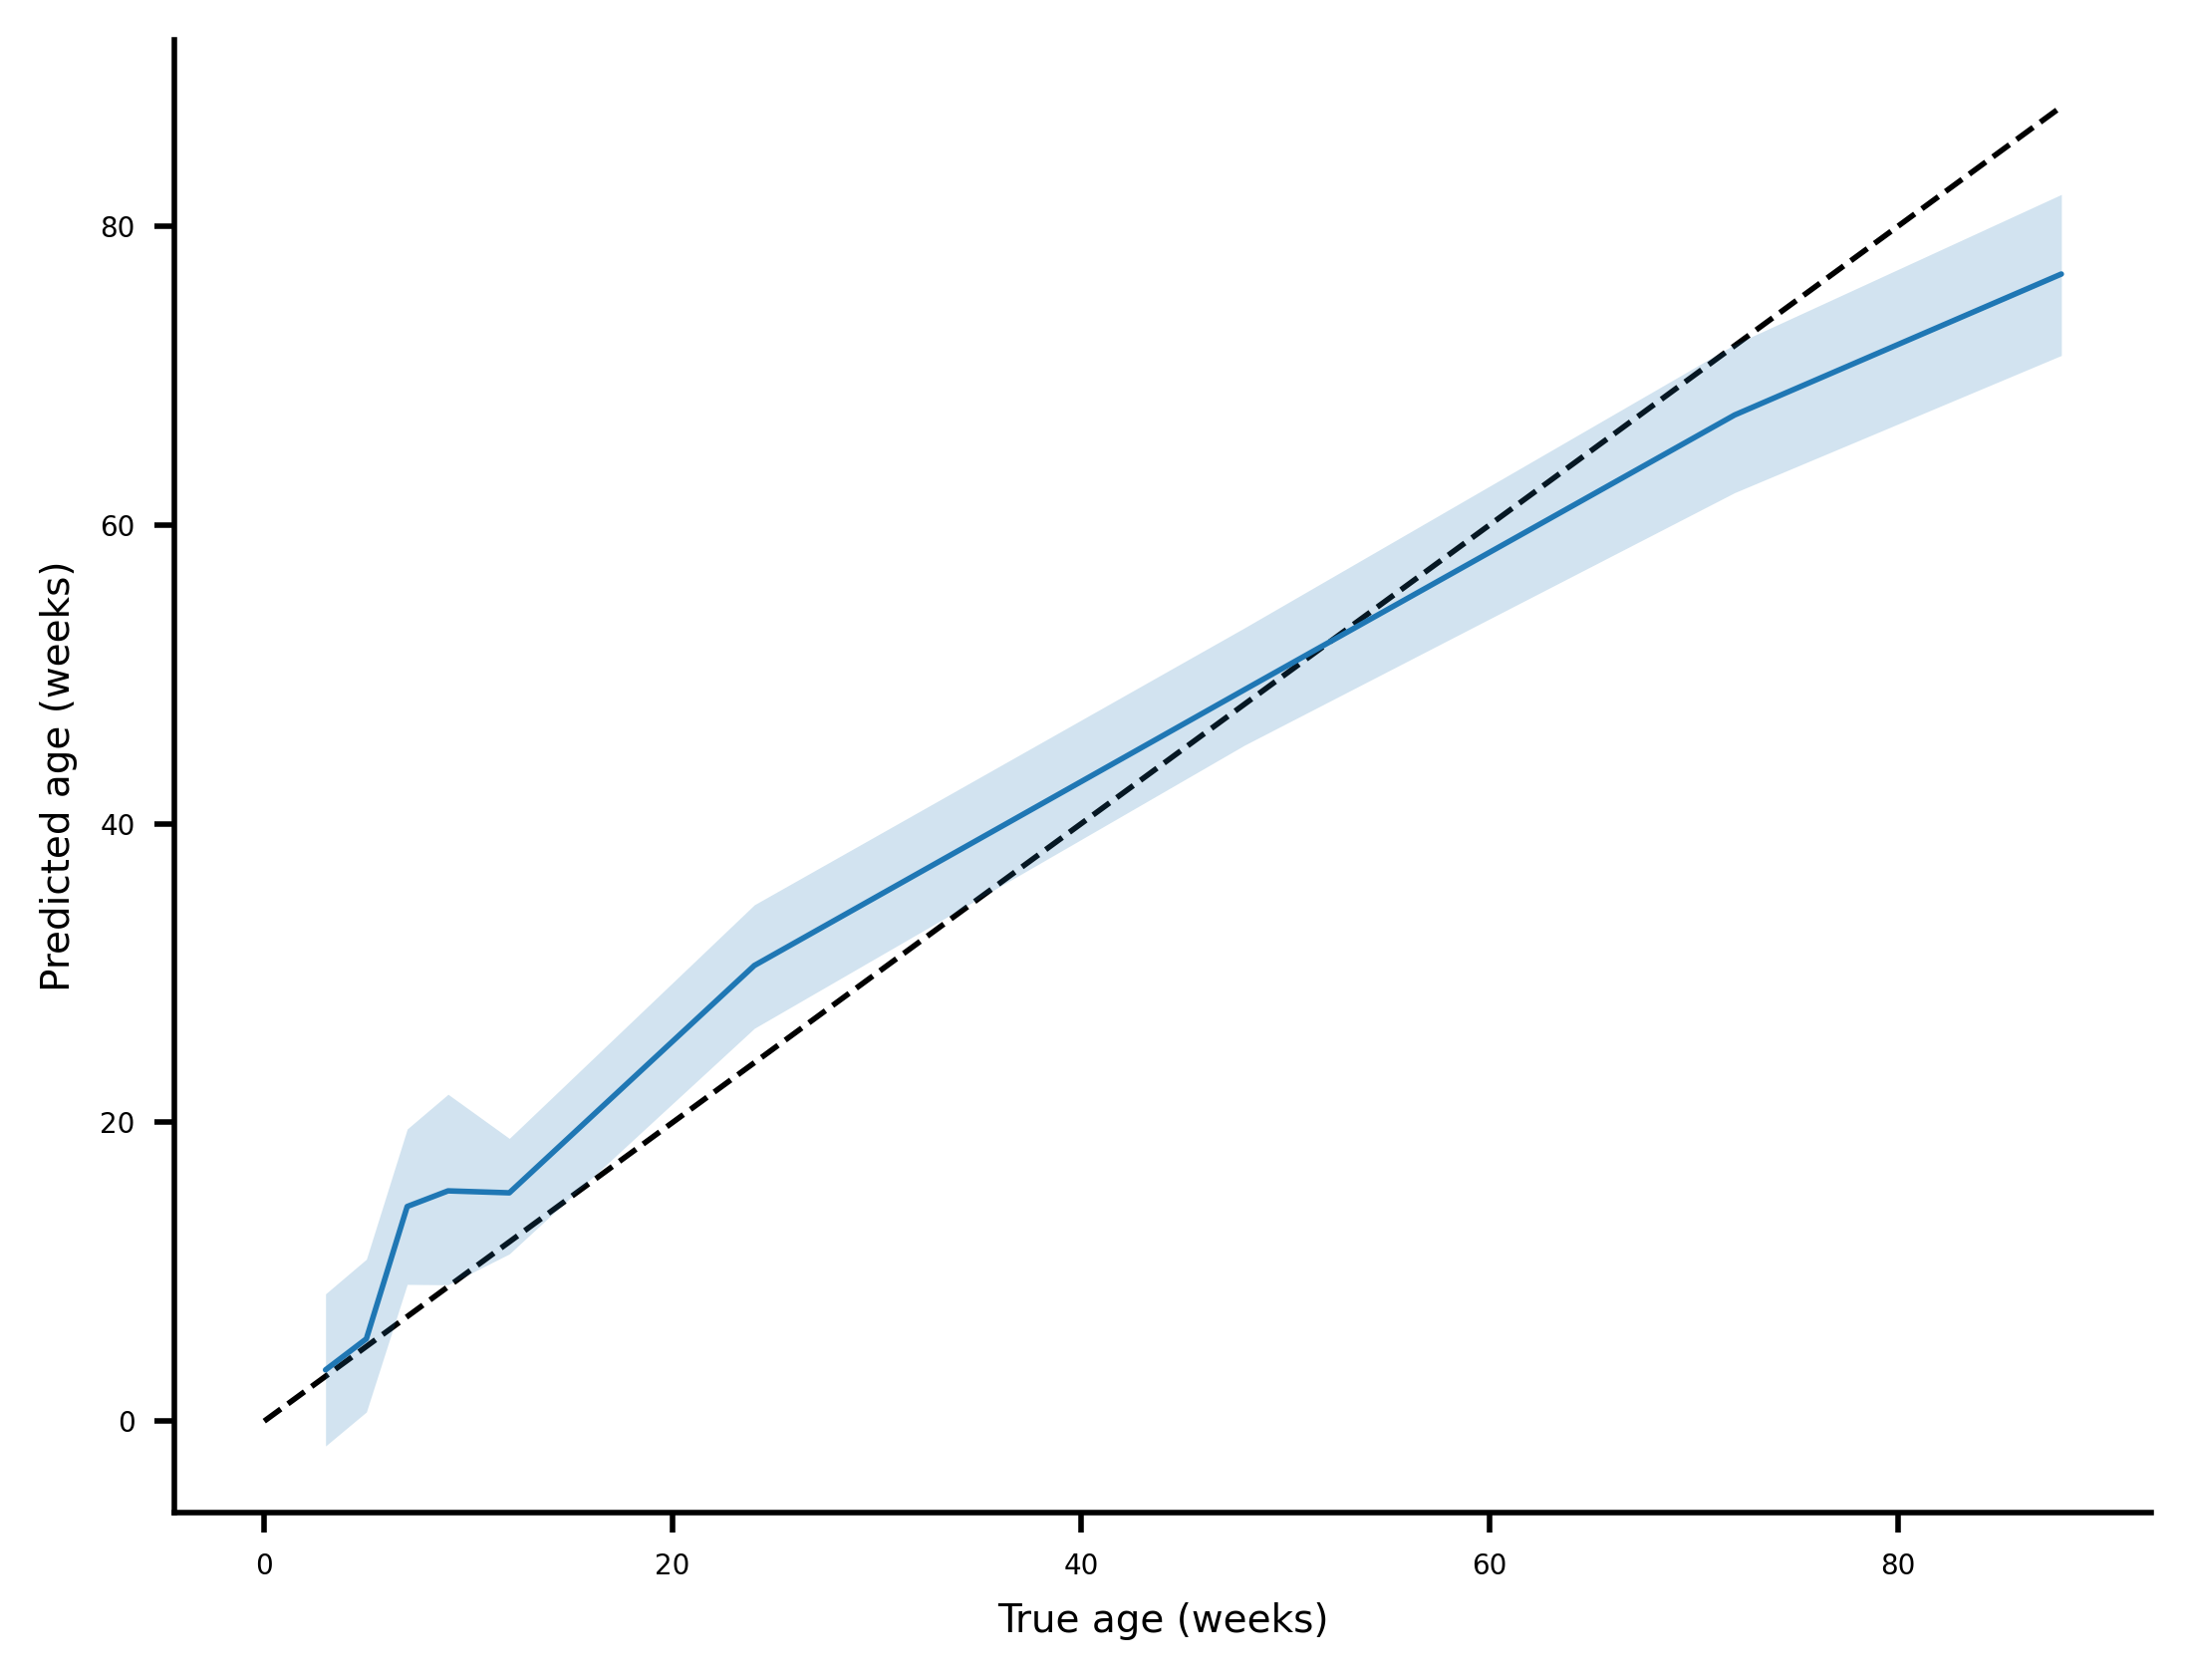

In [99]:
ax = sns.lineplot(y=(preds), x=(y), err_kws=dict(lw=0), zorder=5)
ax.plot([0, 88], [0, 88], color='k', ls='--', zorder=-5)
ax.set(xlabel='True age (weeks)', ylabel='Predicted age (weeks)')
sns.despine()

In [120]:
param_grid = dict(pca__n_components=range(1, 50, 1), elasticnet__alpha=np.round(np.logspace(-3, -1, 6), 3))
grid = ParameterGrid(param_grid)

pipeline = make_pipeline(
    PCA(n_components=30),
    StandardScaler(),
    ElasticNet(alpha=0.05),
)

y = np.log(usage_mtx.index.get_level_values(0))
lbls = LabelEncoder().fit_transform(y)

output = []

for param in tqdm(grid):
    mdl = pipeline.set_params(**param)
    preds = np.zeros_like(y)
    folds = StratifiedKFold(n_splits=5)
    for train, test in folds.split(usage_mtx, lbls):
        pipeline = pipeline.fit(np.log(usage_mtx.iloc[train] + 1e-6), y[train])
        preds[test] = pipeline.predict(np.log(usage_mtx.iloc[test] + 1e-6)).squeeze()
    output.append(dict(params=param, score=r2_score(y, preds)))
out = pd.DataFrame(output)
out.sort_values(by='score', ascending=False).head()

  0%|          | 0/294 [00:00<?, ?it/s]

,params,score
185,"{'elasticnet__alpha': 0.016, 'pca__n_component...",0.857974
184,"{'elasticnet__alpha': 0.016, 'pca__n_component...",0.856491
183,"{'elasticnet__alpha': 0.016, 'pca__n_component...",0.856044
136,"{'elasticnet__alpha': 0.006, 'pca__n_component...",0.855955
181,"{'elasticnet__alpha': 0.016, 'pca__n_component...",0.855188


In [121]:
for i in range(15):
    print(out.sort_values(by='score', ascending=False)['params'].iloc[i])

{'elasticnet__alpha': 0.016, 'pca__n_components': 39}
{'elasticnet__alpha': 0.016, 'pca__n_components': 38}
{'elasticnet__alpha': 0.016, 'pca__n_components': 37}
{'elasticnet__alpha': 0.006, 'pca__n_components': 39}
{'elasticnet__alpha': 0.016, 'pca__n_components': 35}
{'elasticnet__alpha': 0.016, 'pca__n_components': 40}
{'elasticnet__alpha': 0.006, 'pca__n_components': 35}
{'elasticnet__alpha': 0.003, 'pca__n_components': 39}
{'elasticnet__alpha': 0.006, 'pca__n_components': 37}
{'elasticnet__alpha': 0.006, 'pca__n_components': 38}
{'elasticnet__alpha': 0.003, 'pca__n_components': 35}
{'elasticnet__alpha': 0.001, 'pca__n_components': 35}
{'elasticnet__alpha': 0.016, 'pca__n_components': 36}
{'elasticnet__alpha': 0.001, 'pca__n_components': 39}
{'elasticnet__alpha': 0.003, 'pca__n_components': 37}


## Leave out group

In [125]:
param_grid = dict(plsregression__n_components=range(1, 64))
grid = ParameterGrid(param_grid)

pipeline = make_pipeline(
    PLSRegression(n_components=1),
)

y = np.log(usage_mtx.index.get_level_values(0))
lbls = LabelEncoder().fit_transform(y)

output = []

for param in tqdm(grid):
    preds = cross_val_predict(pipeline.set_params(**param), np.log(usage_mtx + 1e-6), y, groups=lbls, cv=LeaveOneGroupOut())
    output.append(dict(params=param, score=r2_score(y, preds)))
out = pd.DataFrame(output)
out.sort_values(by='score', ascending=False).head()

In [135]:
param_grid = dict(pca__n_components=range(1, 63, 1), elasticnet__alpha=np.round(np.logspace(-3, -1, 8), 3))
grid = ParameterGrid(param_grid)

pipeline = make_pipeline(
    PCA(n_components=30),
    StandardScaler(),
    ElasticNet(alpha=0.05),
)

y = np.log(usage_mtx.index.get_level_values(0))
lbls = LabelEncoder().fit_transform(y)

output = []

for param in tqdm(grid):
    preds = cross_val_predict(pipeline.set_params(**param), np.log(usage_mtx + 1e-6), y, groups=lbls, cv=LeaveOneGroupOut())
    output.append(dict(params=param, score=r2_score(y, preds)))
out = pd.DataFrame(output)
out.sort_values(by='score', ascending=False).head()

  0%|          | 0/496 [00:00<?, ?it/s]

,params,score
296,"{'elasticnet__alpha': 0.014, 'pca__n_component...",0.746073
234,"{'elasticnet__alpha': 0.007, 'pca__n_component...",0.745420
172,"{'elasticnet__alpha': 0.004, 'pca__n_component...",0.744761
110,"{'elasticnet__alpha': 0.002, 'pca__n_component...",0.744212
294,"{'elasticnet__alpha': 0.014, 'pca__n_component...",0.743929


In [136]:
for i in range(6):
    print(out.sort_values(by='score', ascending=False)['params'].iloc[i])

{'elasticnet__alpha': 0.014, 'pca__n_components': 49}
{'elasticnet__alpha': 0.007, 'pca__n_components': 49}
{'elasticnet__alpha': 0.004, 'pca__n_components': 49}
{'elasticnet__alpha': 0.002, 'pca__n_components': 49}
{'elasticnet__alpha': 0.014, 'pca__n_components': 47}
{'elasticnet__alpha': 0.001, 'pca__n_components': 49}


In [142]:
# pipeline = make_pipeline(
#     PCA(n_components=49),
#     StandardScaler(),
#     ElasticNet(alpha=0.014, l1_ratio=0.5),
# )
pipeline = make_pipeline(
    PLSRegression(n_components=5),
)

y = np.log(usage_mtx.index.get_level_values(0))
preds = cross_val_predict(pipeline, np.log(usage_mtx + 1e-6), y, groups=y.copy(), cv=LeaveOneGroupOut()).squeeze()
r2_score(y, preds)

0.7847221227234766

In [143]:
avg_preds = pd.Series(preds).groupby(y).median()
y_unique = pd.Series(y).groupby(y).mean()

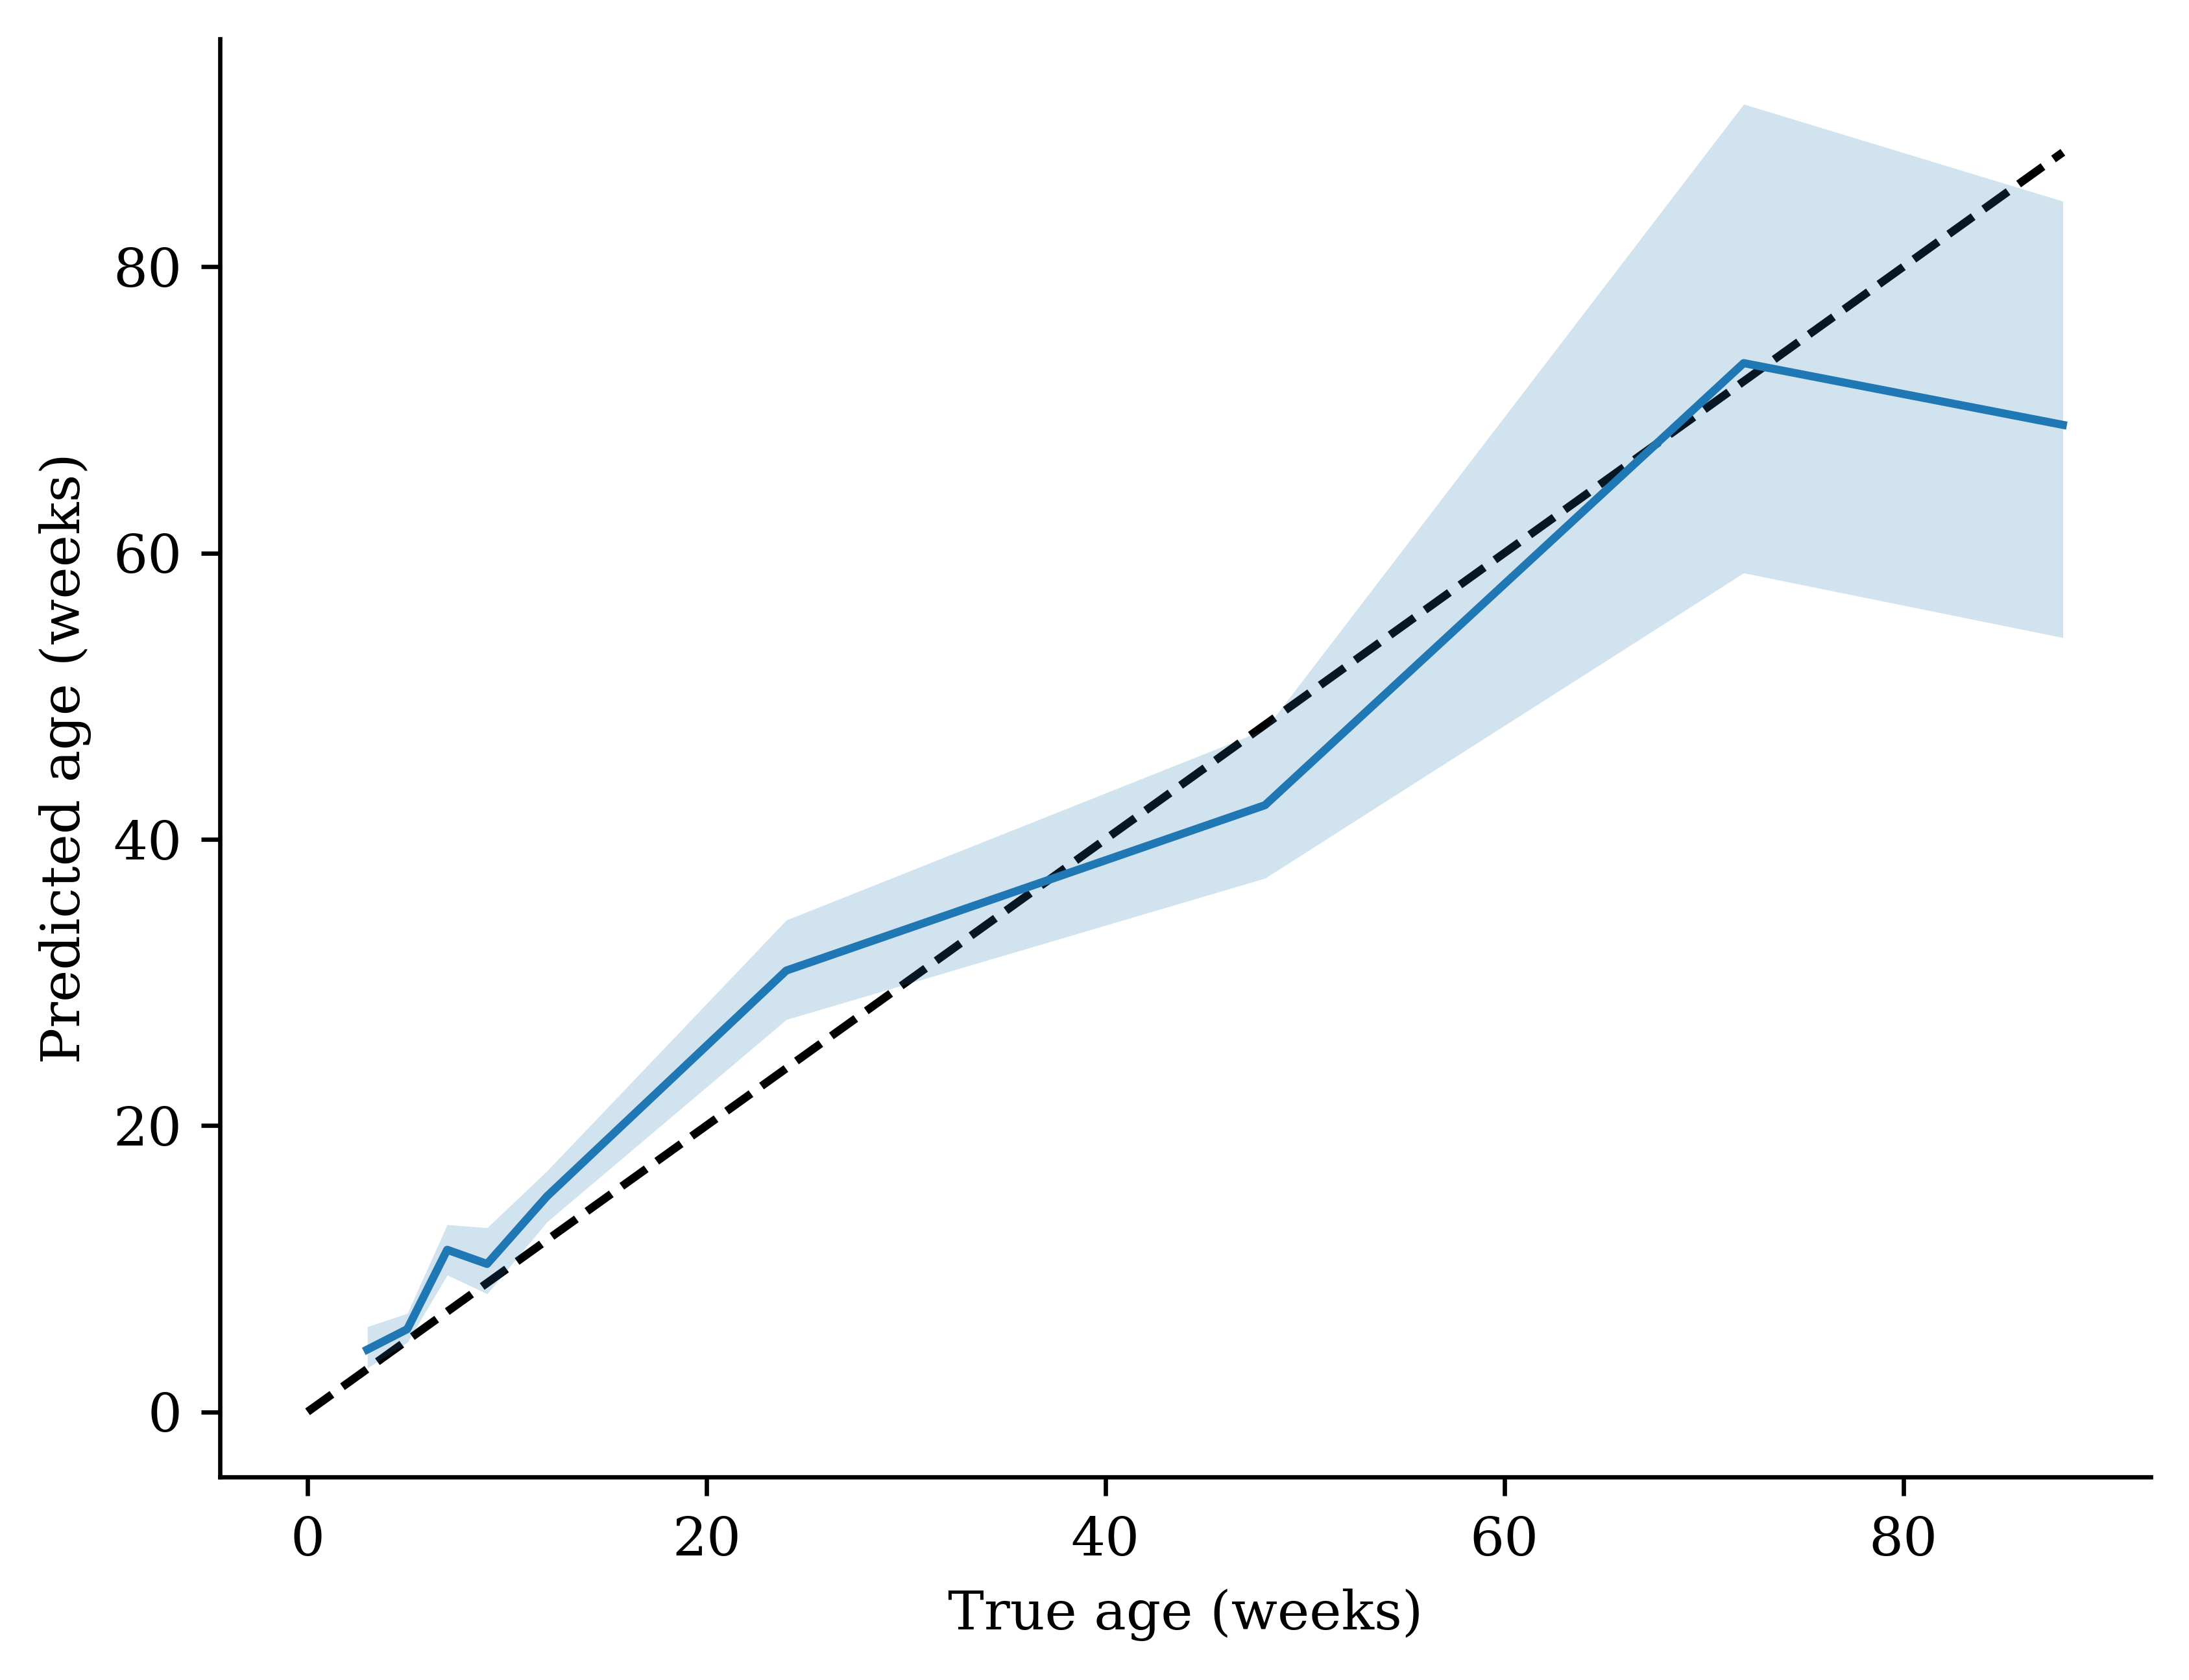

In [144]:
ax = sns.lineplot(y=np.exp(preds), x=np.exp(y), err_kws=dict(lw=0), zorder=5)
ax.plot([0, 88], [0, 88], color='k', ls='--', zorder=-5)
ax.set(xlabel='True age (weeks)', ylabel='Predicted age (weeks)')
sns.despine()

# TMs

## Leave out fraction of each group

In [178]:
param_grid = dict(plsregression__n_components=range(1, 40))
grid = ParameterGrid(param_grid)

pipeline = make_pipeline(
    PLSRegression(n_components=1),
)

y = np.log(tm_mtx.index.get_level_values(0))
lbls = LabelEncoder().fit_transform(y)

output = []

for param in tqdm(grid):
    mdl = pipeline.set_params(**param)
    preds = np.zeros_like(y)
    folds = StratifiedKFold(n_splits=5)
    for train, test in folds.split(usage_mtx, lbls):
        pipeline = pipeline.fit((tm_mtx.iloc[train] + 1e-6), y[train])
        preds[test] = pipeline.predict((tm_mtx.iloc[test] + 1e-6)).squeeze()
    output.append(dict(params=param, score=r2_score(y, preds)))

out = pd.DataFrame(output)
out.sort_values(by='score', ascending=False).head()

  0%|          | 0/39 [00:00<?, ?it/s]

,params,score
4,{'plsregression__n_components': 5},0.836932
5,{'plsregression__n_components': 6},0.836901
6,{'plsregression__n_components': 7},0.835078
7,{'plsregression__n_components': 8},0.832440
3,{'plsregression__n_components': 4},0.830088


In [177]:
pipeline = make_pipeline(
    PLSRegression(n_components=5),
)

y = np.log(tm_mtx.index.get_level_values(0))
lbls = LabelEncoder().fit_transform(y)

preds = np.zeros_like(y)
folds = StratifiedKFold(n_splits=5)
for train, test in folds.split(tm_mtx, lbls):
    pipeline = pipeline.fit((tm_mtx.iloc[train] + 1e-6), y[train])
    preds[test] = pipeline.predict((tm_mtx.iloc[test] + 1e-6)).squeeze()

r2_score(y, preds)

0.8369323688659569

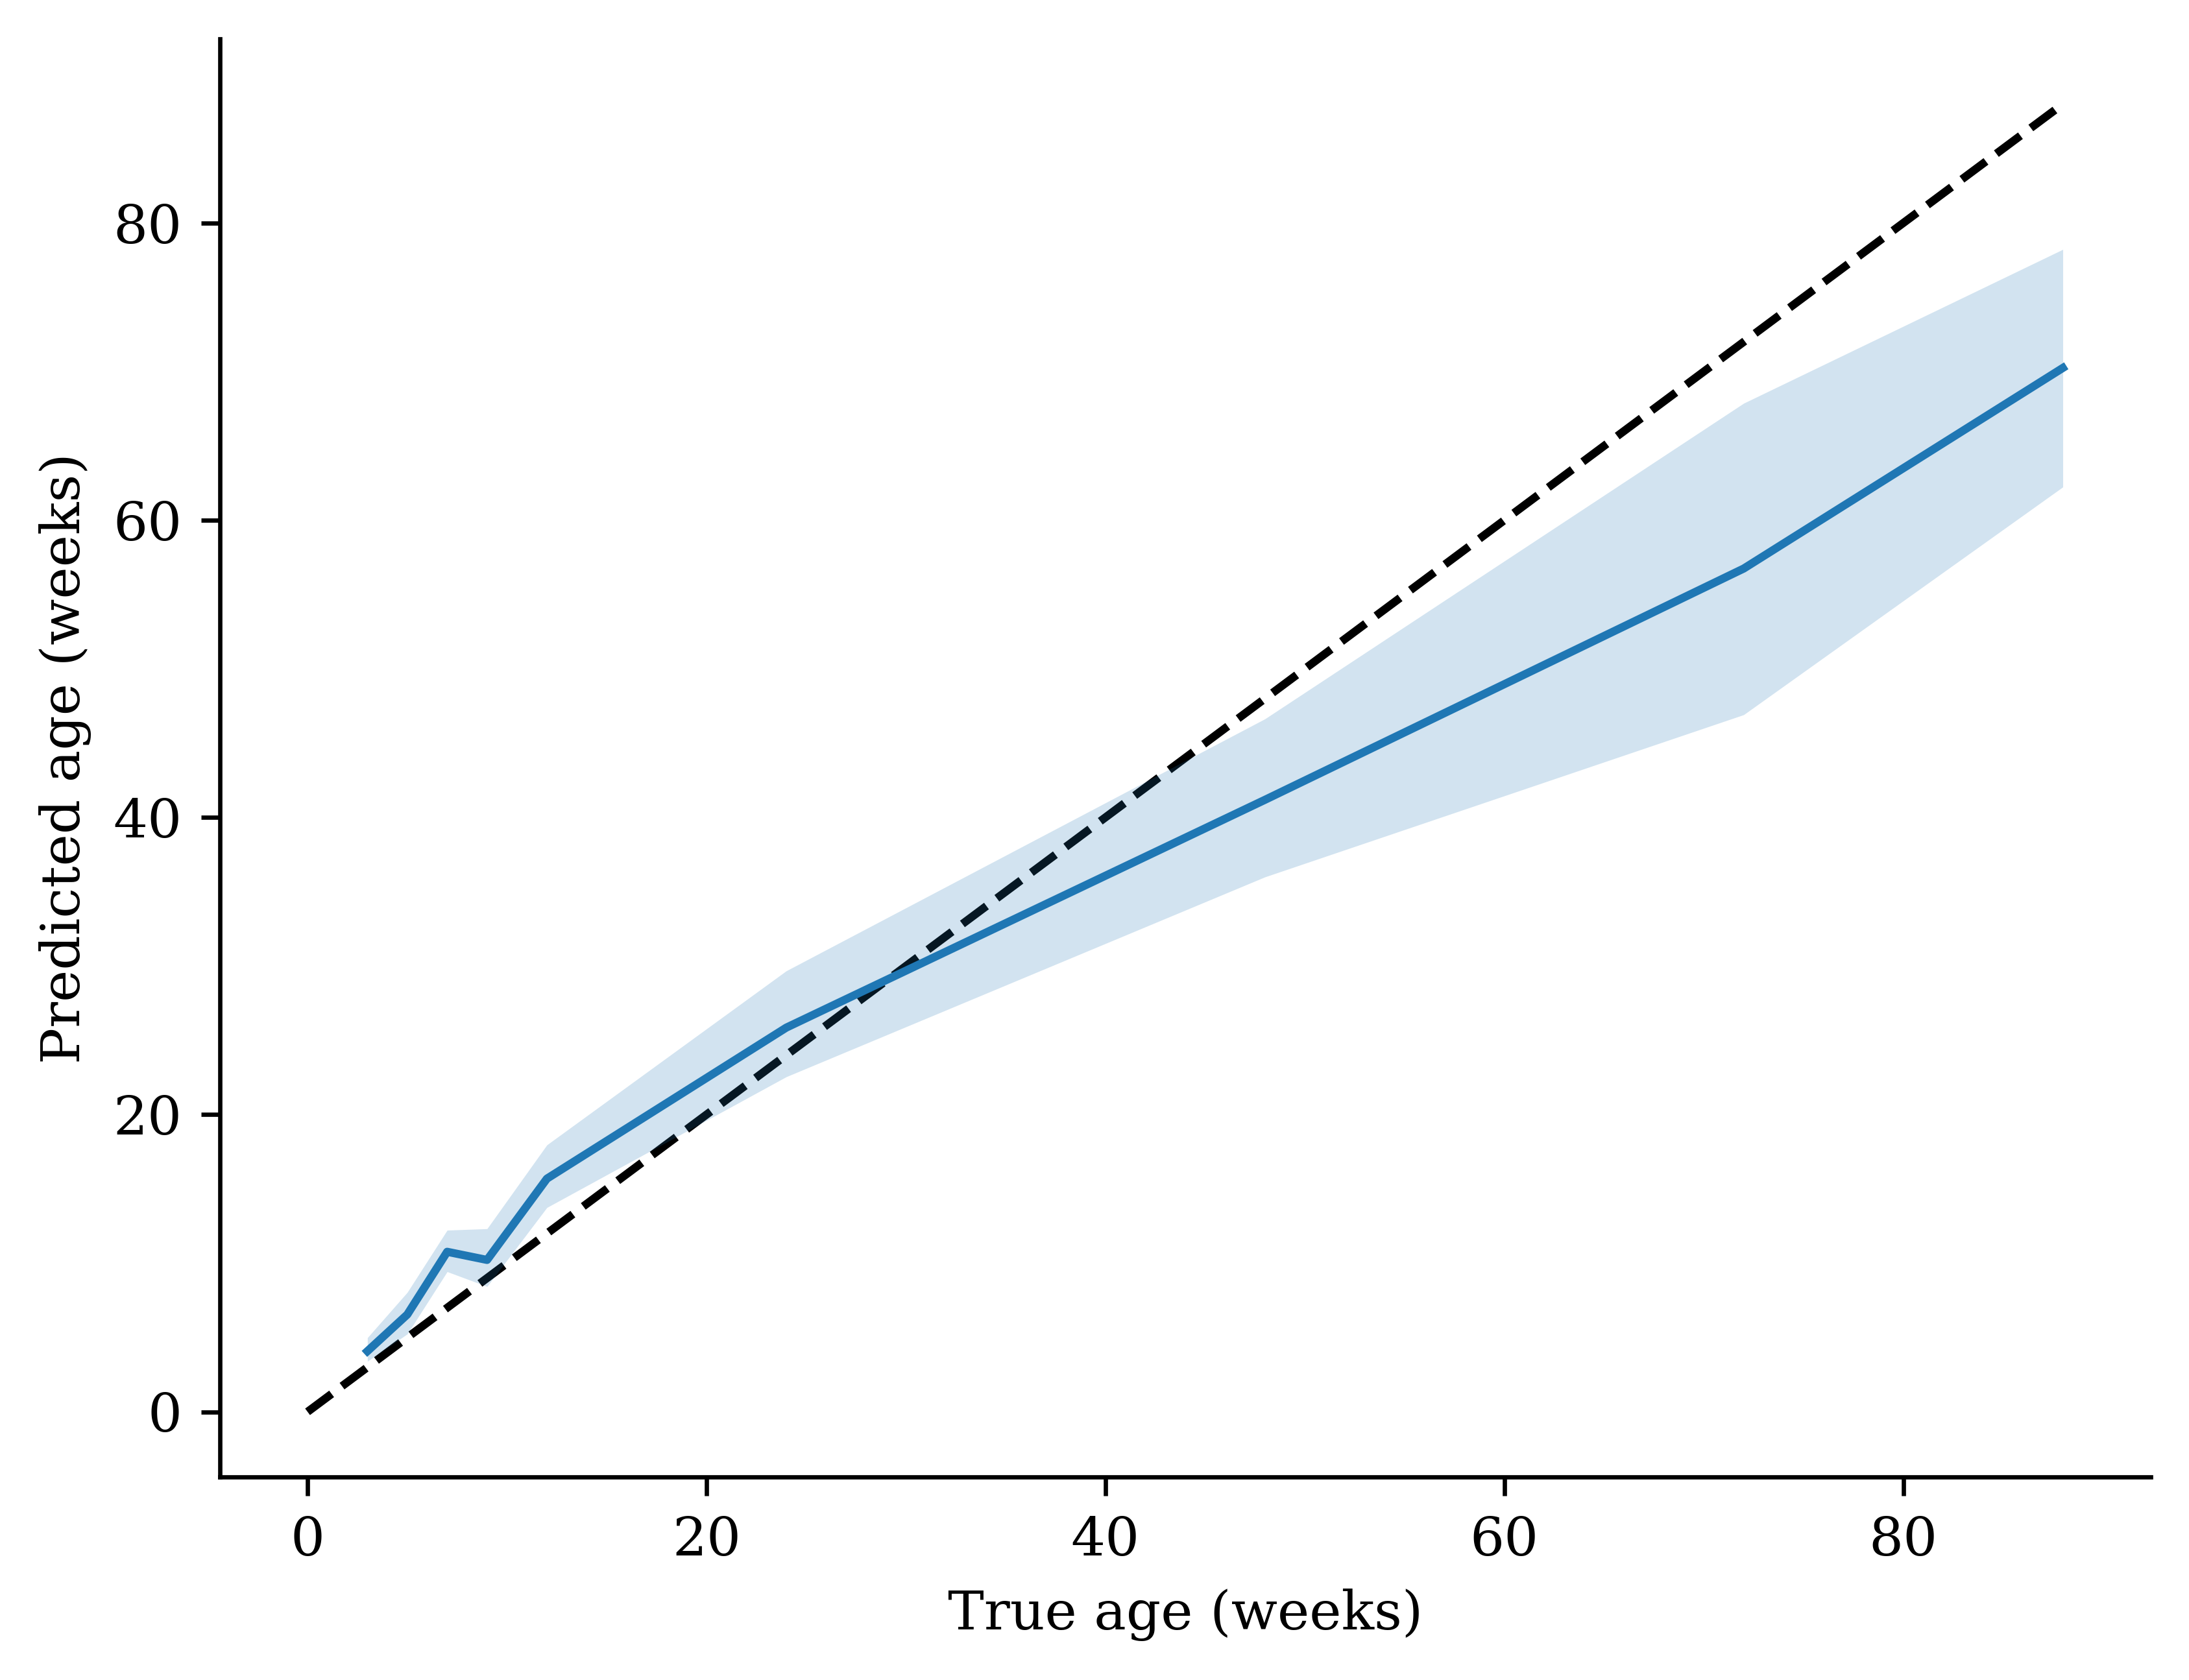

In [153]:
ax = sns.lineplot(y=np.exp(preds), x=np.exp(y), err_kws=dict(lw=0), zorder=5)
ax.plot([0, 88], [0, 88], color='k', ls='--', zorder=-5)
ax.set(xlabel='True age (weeks)', ylabel='Predicted age (weeks)')
sns.despine()

In [170]:
param_grid = dict(pca__n_components=range(1, 50, 2), elasticnet__alpha=np.round(np.logspace(-3, -1, 6), 3))
grid = ParameterGrid(param_grid)

pipeline = make_pipeline(
    PCA(n_components=30),
    StandardScaler(),
    ElasticNet(alpha=0.05),
)

y = np.log(tm_mtx.index.get_level_values(0))
lbls = LabelEncoder().fit_transform(y)

output = []

for param in tqdm(grid):
    mdl = pipeline.set_params(**param)
    preds = np.zeros_like(y)
    folds = StratifiedKFold(n_splits=5)
    for train, test in folds.split(tm_mtx, lbls):
        pipeline = pipeline.fit((tm_mtx.iloc[train] + 1e-6), y[train])
        preds[test] = pipeline.predict((tm_mtx.iloc[test] + 1e-6)).squeeze()
    output.append(dict(params=param, score=r2_score(y, preds)))
out = pd.DataFrame(output)
out.sort_values(by='score', ascending=False).head()

  0%|          | 0/150 [00:00<?, ?it/s]

,params,score
48,"{'elasticnet__alpha': 0.003, 'pca__n_component...",0.842389
22,"{'elasticnet__alpha': 0.001, 'pca__n_component...",0.842140
23,"{'elasticnet__alpha': 0.001, 'pca__n_component...",0.841750
46,"{'elasticnet__alpha': 0.003, 'pca__n_component...",0.841672
44,"{'elasticnet__alpha': 0.003, 'pca__n_component...",0.840897


In [171]:
out.sort_values(by='score', ascending=False)['params'].iloc[0]

{'elasticnet__alpha': 0.003, 'pca__n_components': 47}

In [175]:
pipeline = make_pipeline(
    PCA(n_components=47),
    StandardScaler(),
    ElasticNet(alpha=0.003),
)

y = np.log(tm_mtx.index.get_level_values(0))
lbls = LabelEncoder().fit_transform(y)

preds = np.zeros_like(y)
folds = StratifiedKFold(n_splits=5)
for train, test in folds.split(tm_mtx, lbls):
    pipeline = pipeline.fit((tm_mtx.iloc[train] + 1e-6), y[train])
    preds[test] = pipeline.predict((tm_mtx.iloc[test] + 1e-6)).squeeze()

r2_score(y, preds)

0.8434814464574856

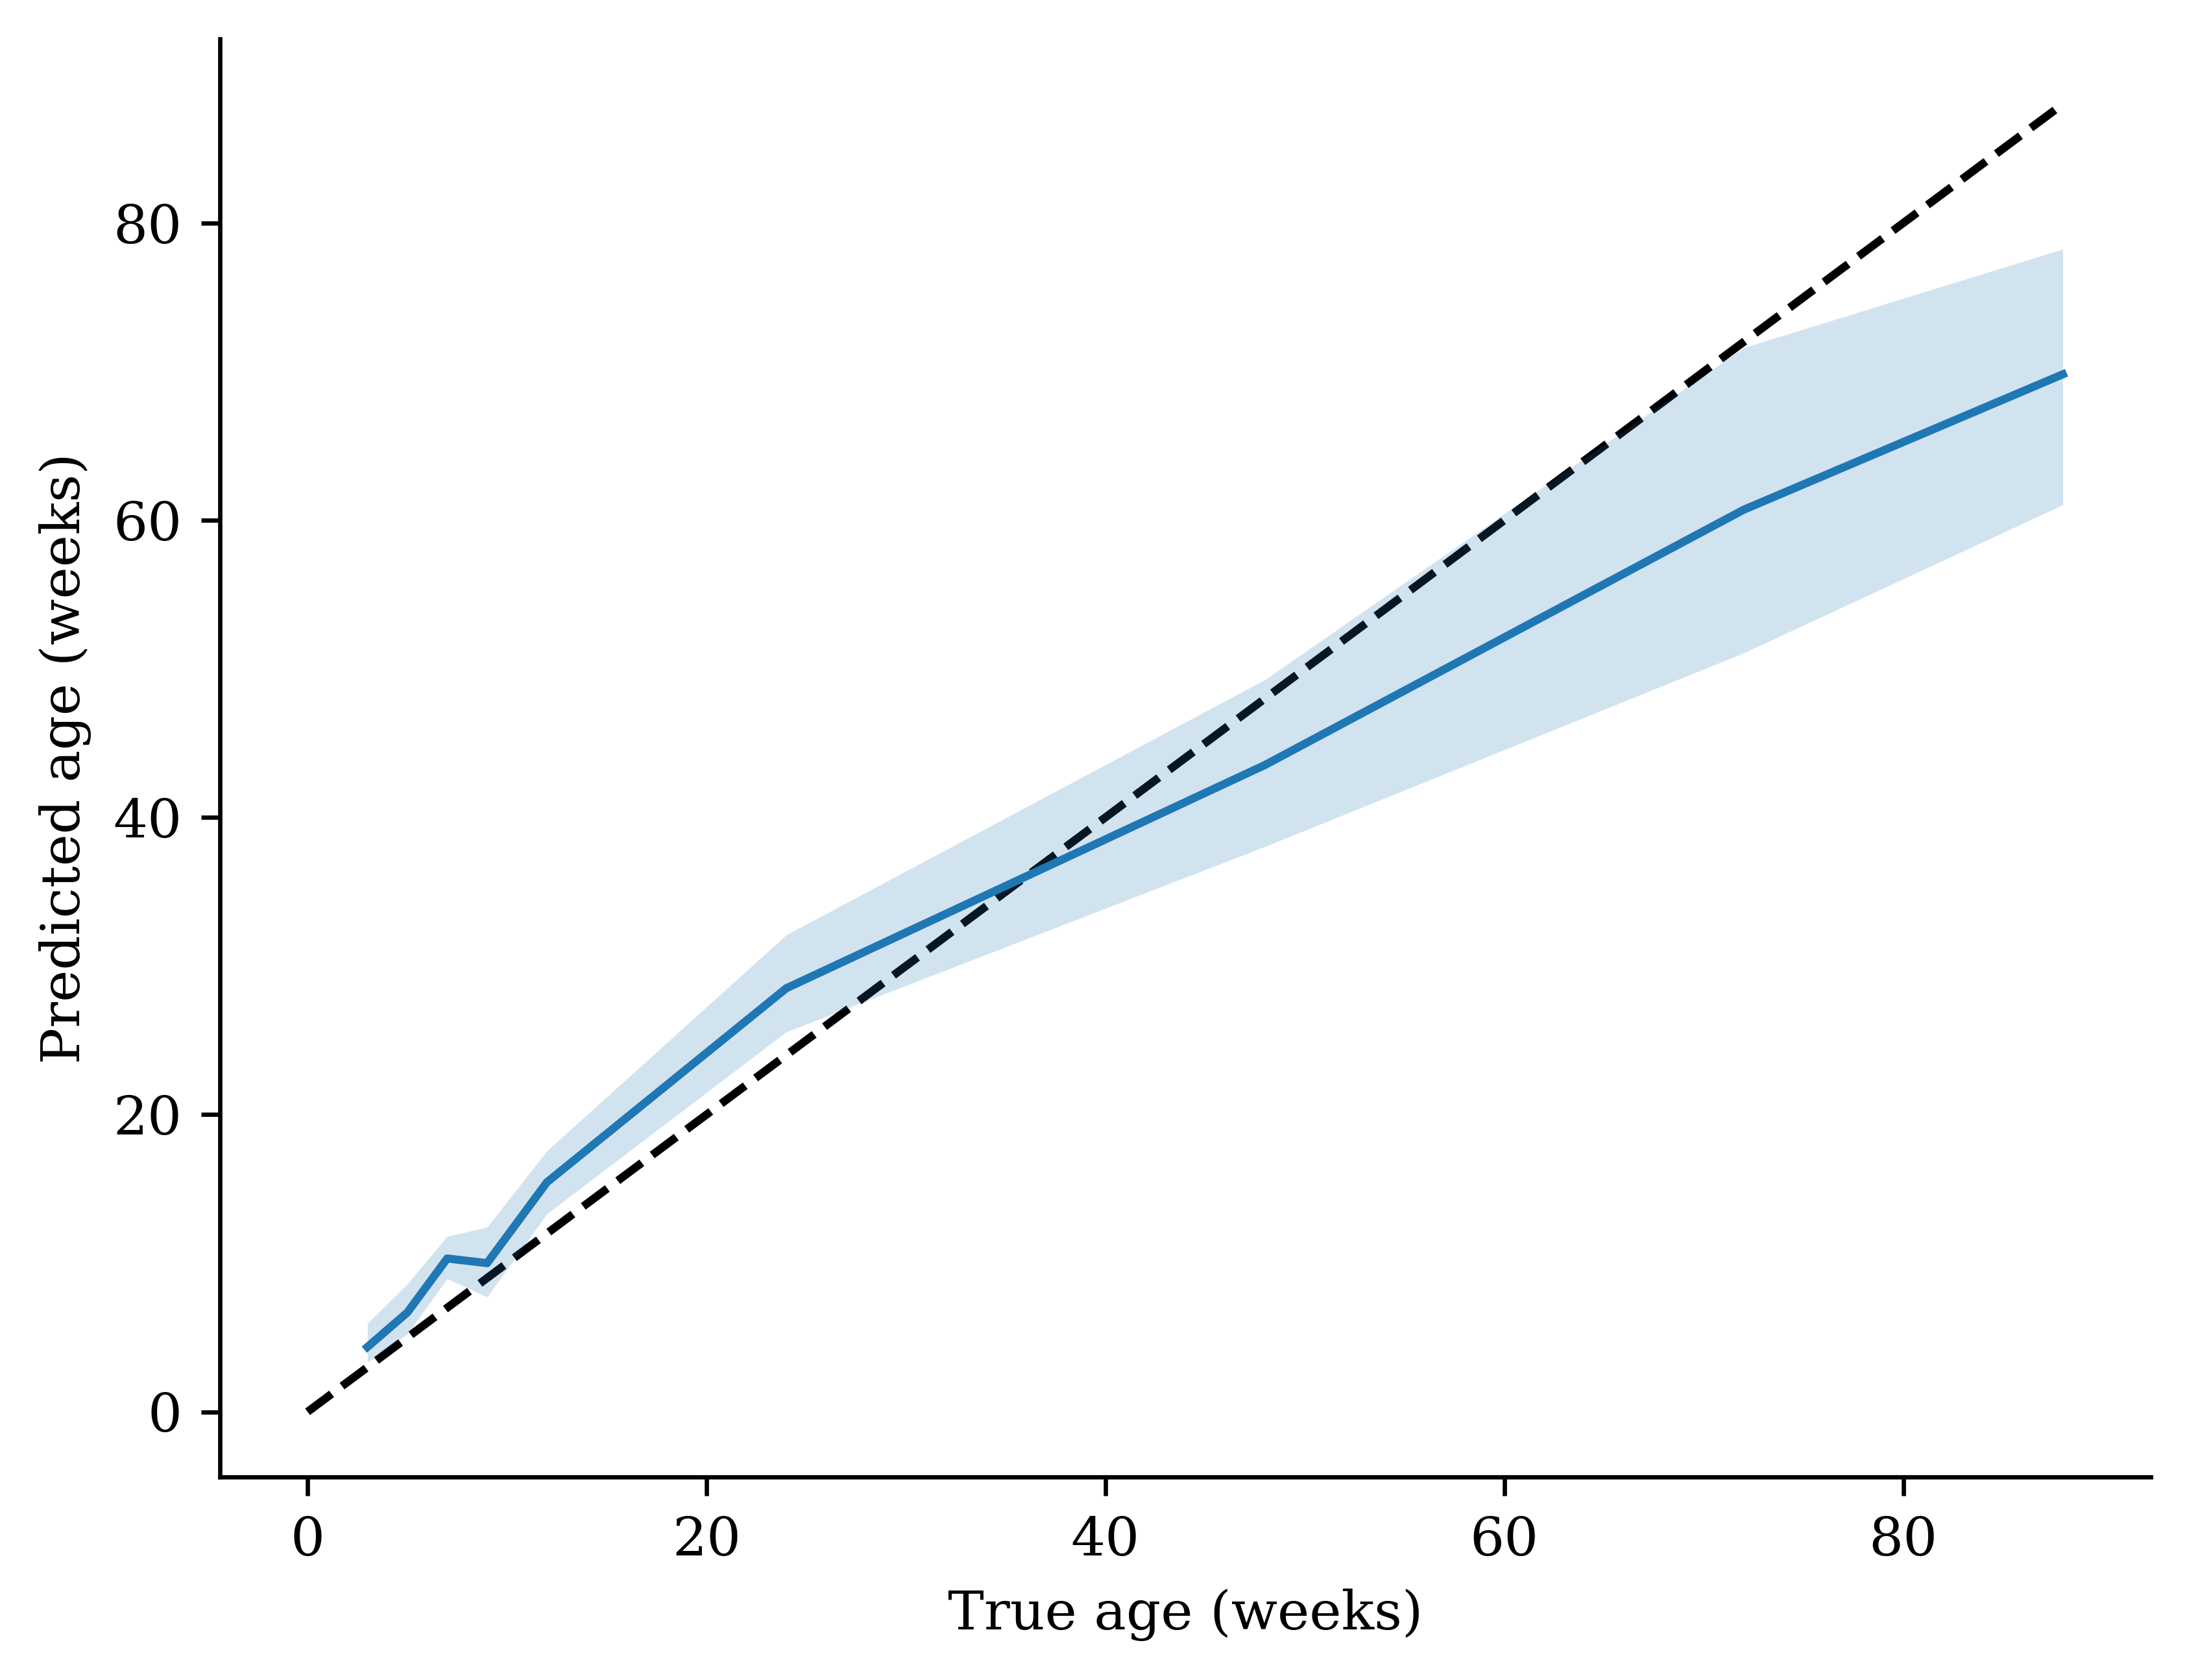

In [176]:
ax = sns.lineplot(y=np.exp(preds), x=np.exp(y), err_kws=dict(lw=0), zorder=5)
ax.plot([0, 88], [0, 88], color='k', ls='--', zorder=-5)
ax.set(xlabel='True age (weeks)', ylabel='Predicted age (weeks)')
sns.despine()

## Leave out group

In [159]:
param_grid = dict(plsregression__n_components=range(1, 30))
grid = ParameterGrid(param_grid)

pipeline = make_pipeline(
    PLSRegression(n_components=1),
)

y = np.log(tm_mtx.index.get_level_values(0))
lbls = LabelEncoder().fit_transform(y)

output = []

for param in tqdm(grid):
    preds = cross_val_predict(pipeline.set_params(**param), (tm_mtx + 1e-6), y, groups=lbls, cv=LeaveOneGroupOut())
    output.append(dict(params=param, score=r2_score(y, preds)))
out = pd.DataFrame(output)
out.sort_values(by='score', ascending=False).head()

  0%|          | 0/29 [00:00<?, ?it/s]

,params,score
3,{'plsregression__n_components': 4},0.748809
7,{'plsregression__n_components': 8},0.734860
5,{'plsregression__n_components': 6},0.730109
8,{'plsregression__n_components': 9},0.729153
9,{'plsregression__n_components': 10},0.728158


In [162]:
pipeline = make_pipeline(
    PLSRegression(n_components=4),
)

y = np.log(tm_mtx.index.get_level_values(0))
preds = cross_val_predict(pipeline, (tm_mtx + 1e-6), y, groups=lbls, cv=LeaveOneGroupOut()).squeeze()
r2_score(y, preds)

0.7488094996502369

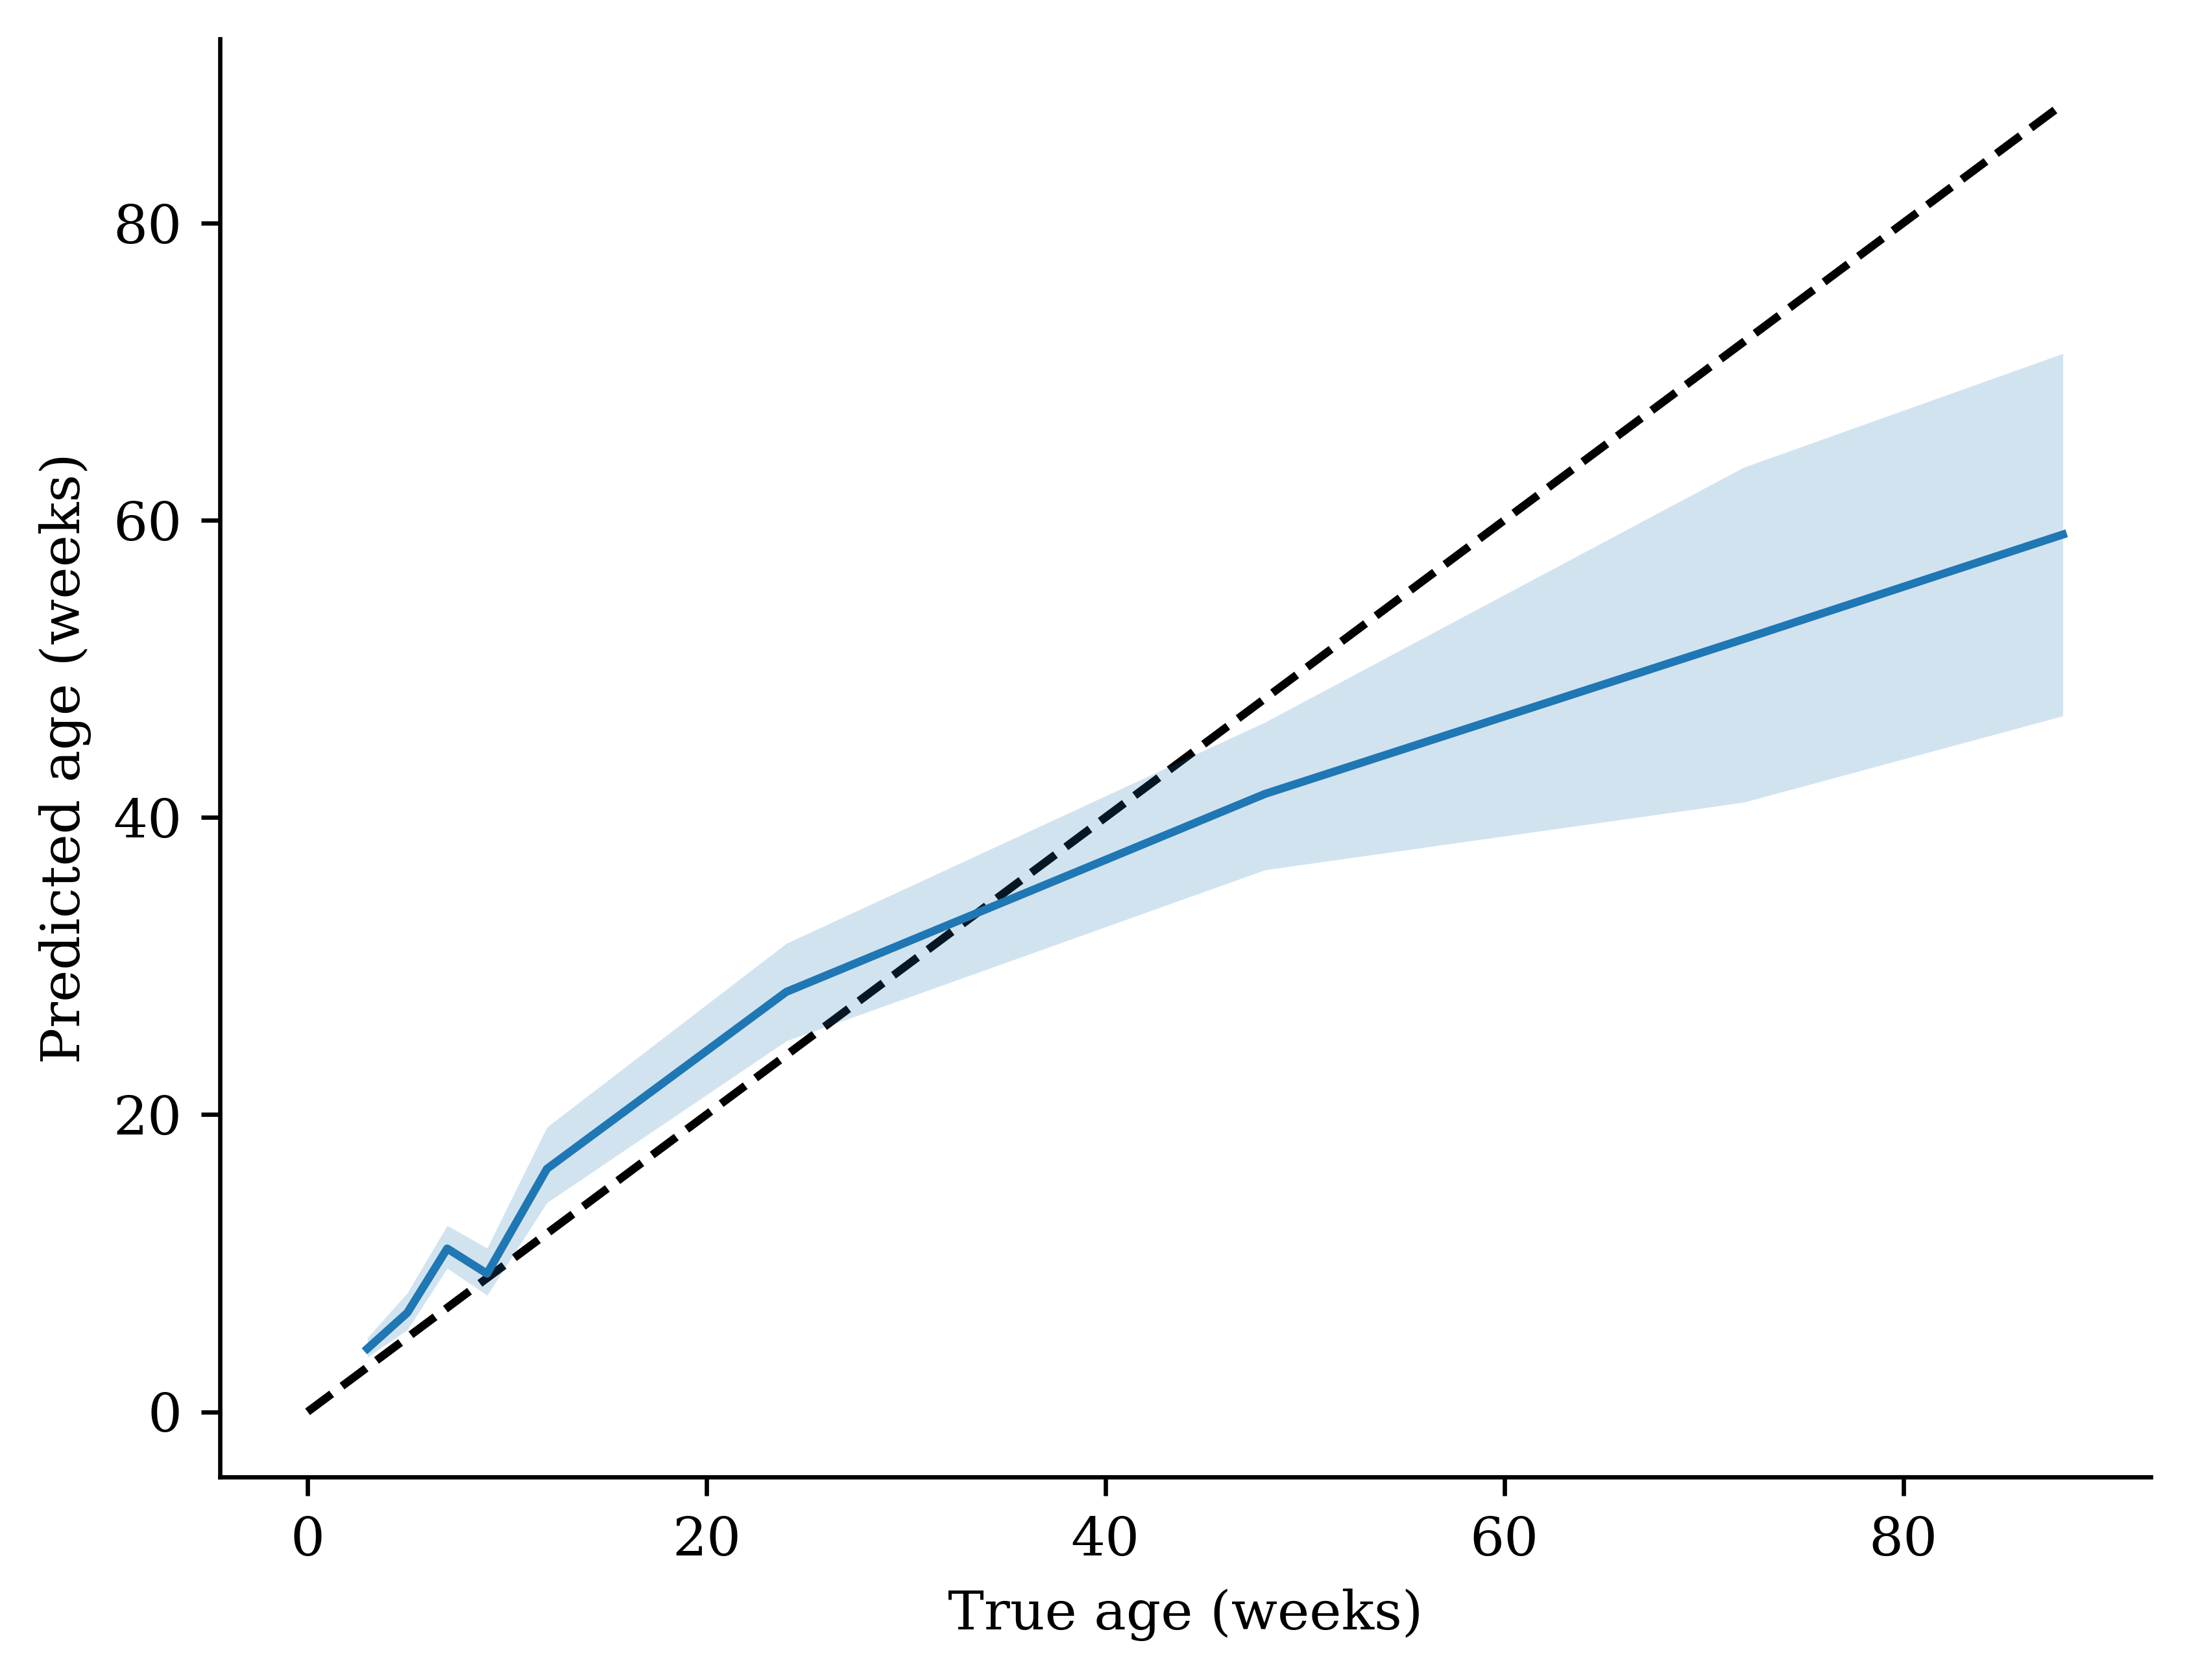

In [163]:
ax = sns.lineplot(y=np.exp(preds), x=np.exp(y), err_kws=dict(lw=0), zorder=5)
ax.plot([0, 88], [0, 88], color='k', ls='--', zorder=-5)
ax.set(xlabel='True age (weeks)', ylabel='Predicted age (weeks)')
sns.despine()

In [185]:
param_grid = dict(pca__n_components=range(1, 50, 3), elasticnet__alpha=np.round(np.logspace(-3, -2, 3), 3))
grid = ParameterGrid(param_grid)

pipeline = make_pipeline(
    PCA(n_components=30),
    StandardScaler(),
    ElasticNet(alpha=0.05),
)

y = np.log(tm_mtx.index.get_level_values(0))
lbls = LabelEncoder().fit_transform(y)

output = []

for param in tqdm(grid):
    preds = cross_val_predict(pipeline.set_params(**param), (tm_mtx + 1e-6), y, groups=lbls, cv=LeaveOneGroupOut())
    output.append(dict(params=param, score=r2_score(y, preds)))
out = pd.DataFrame(output)
out.sort_values(by='score', ascending=False).head()

  0%|          | 0/51 [00:00<?, ?it/s]

,params,score
16,"{'elasticnet__alpha': 0.001, 'pca__n_component...",0.732146
15,"{'elasticnet__alpha': 0.001, 'pca__n_component...",0.731441
32,"{'elasticnet__alpha': 0.003, 'pca__n_component...",0.728538
31,"{'elasticnet__alpha': 0.003, 'pca__n_component...",0.726802
33,"{'elasticnet__alpha': 0.003, 'pca__n_component...",0.726174


In [186]:
out.sort_values(by='score', ascending=False)['params'].iloc[0]

{'elasticnet__alpha': 0.001, 'pca__n_components': 49}

In [187]:
pipeline = make_pipeline(
    PCA(n_components=49),
    StandardScaler(),
    ElasticNet(alpha=0.001),
)

y = np.log(tm_mtx.index.get_level_values(0))
lbls = LabelEncoder().fit_transform(y)

preds = cross_val_predict(pipeline.set_params(**param), (tm_mtx + 1e-6), y, groups=lbls, cv=LeaveOneGroupOut())
r2_score(y, preds)

0.7229405009373833

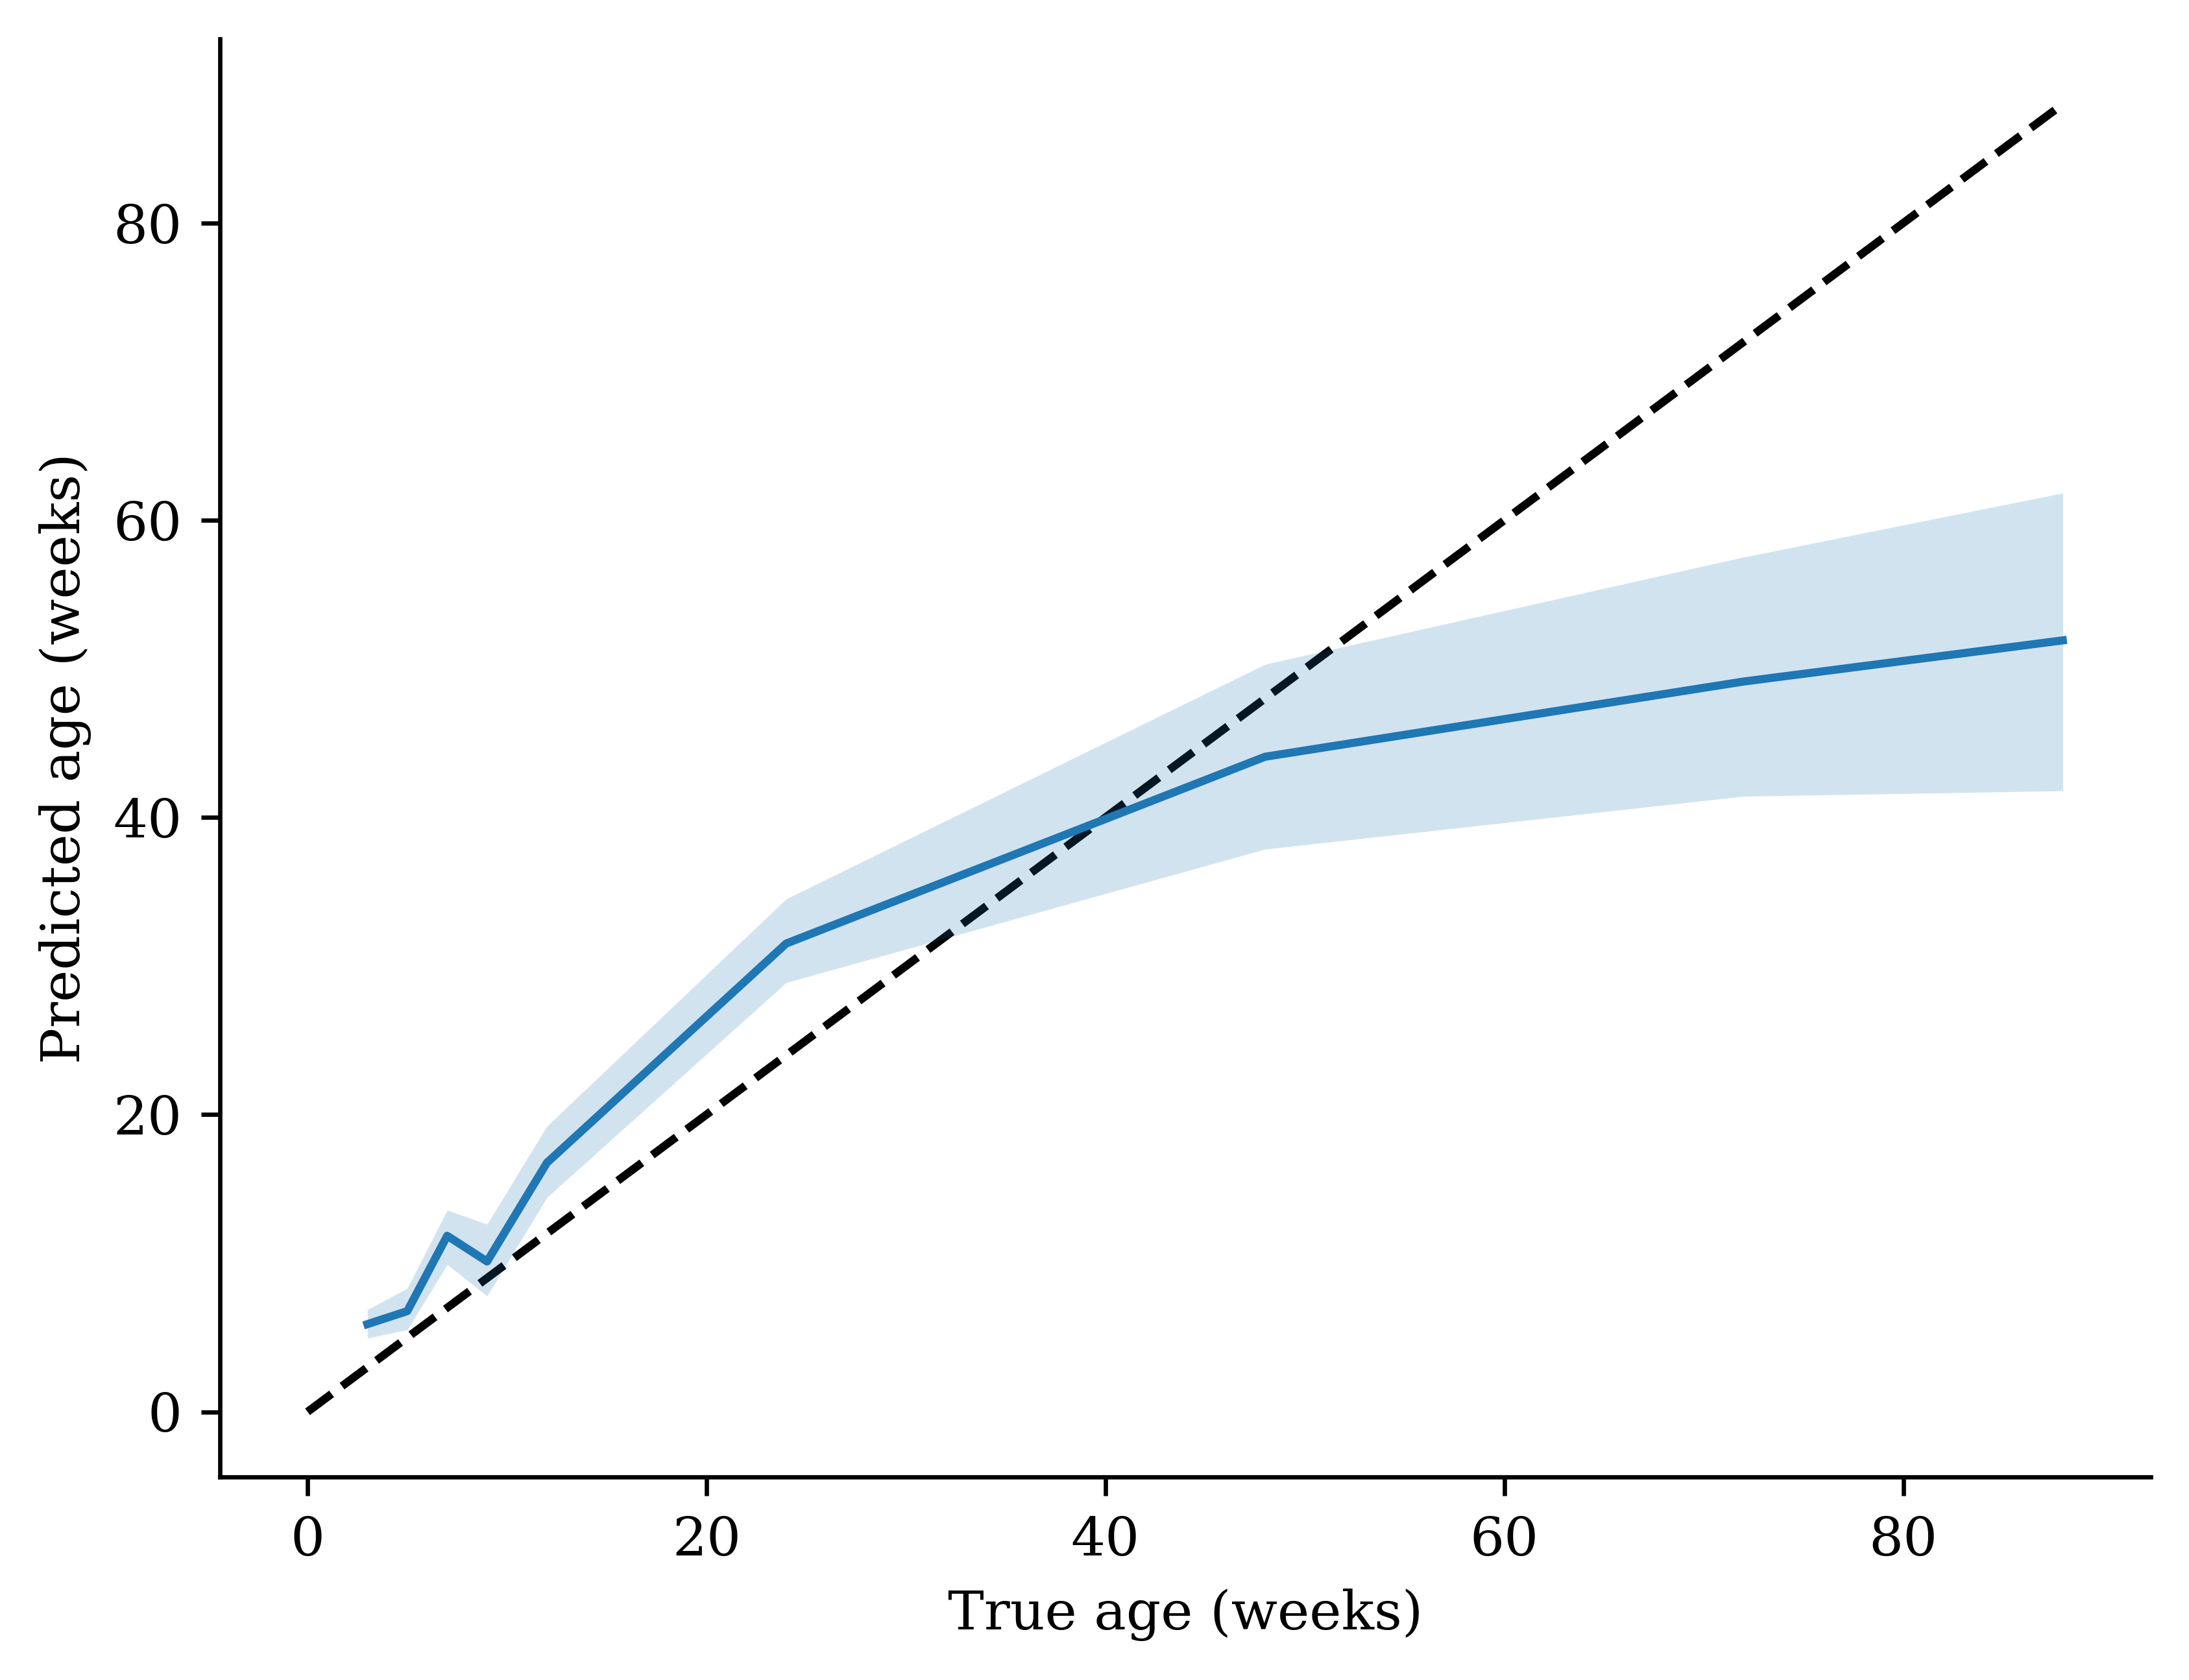

In [188]:
ax = sns.lineplot(y=np.exp(preds), x=np.exp(y), err_kws=dict(lw=0), zorder=5)
ax.plot([0, 88], [0, 88], color='k', ls='--', zorder=-5)
ax.set(xlabel='True age (weeks)', ylabel='Predicted age (weeks)')
sns.despine()

# Figures

## Syllable vs age regression + scatter

In [9]:
pipeline = make_pipeline(
    PLSRegression(n_components=5),
)

y = np.log(usage_mtx.index.get_level_values(0))
preds = cross_val_predict(pipeline, np.log(usage_mtx + 1e-6), y, groups=y.copy(), cv=LeaveOneGroupOut()).squeeze()
score = r2_score(y, preds)

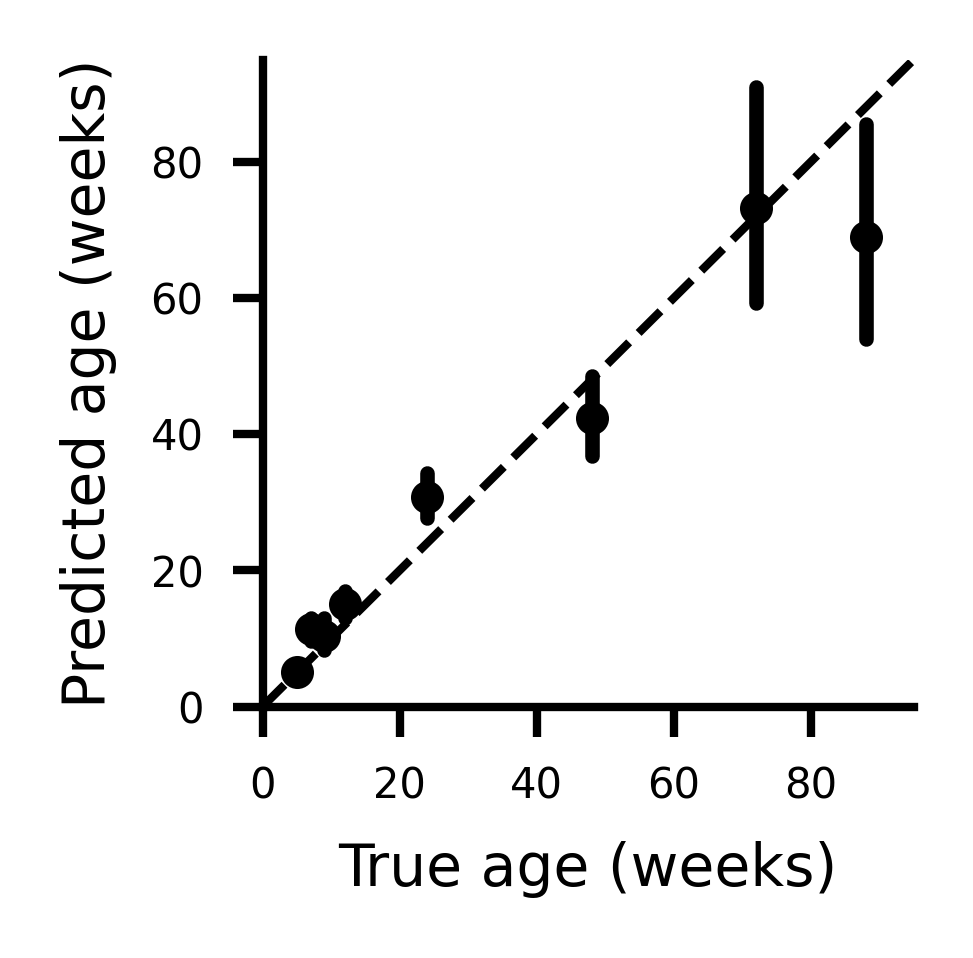

In [20]:
fig = figure(1.4, 1.4)
ax = sns.regplot(y=np.exp(preds), x=np.exp(y), x_bins=9, fit_reg=False, color='k', scatter_kws=dict(s=10))
ax.plot([0, 95], [0, 95], color='k', ls='--', zorder=-5)
ax.set(xlabel='True age (weeks)', ylabel='Predicted age (weeks)', xlim=(0, 95), ylim=(0, 95))
sns.despine()
saver(fig, 'syllable-usage-age-regression-ontogeny-males');

## Syllable vs age shuffle

In [71]:
n_shuffs = 500
np.random.seed(0)
y = np.log(usage_mtx.index.get_level_values(0)).to_numpy()
lbls = pd.Series(LabelEncoder().fit_transform(y))

shuff_scores = []
for i in tqdm(range(n_shuffs)):
    np.random.shuffle(y)
    # lbl_order = np.unique(lbls)
    # np.random.shuffle(lbl_order)
    # new_y = y.copy()
    # for i, l in enumerate(lbl_order):
    #     new_y[lbls == l] = y[lbls == i][0]
    # new_lbls = LabelEncoder().fit_transform(new_y)
    # preds = cross_val_predict(pipeline, np.log(usage_mtx + 1e-6), new_y, groups=new_lbls, cv=LeaveOneGroupOut()).squeeze()
    preds = cross_val_predict(pipeline, np.log(usage_mtx + 1e-6), y, groups=lbls, cv=LeaveOneGroupOut()).squeeze()
    shuff_scores.append(r2_score(y, preds))

  0%|          | 0/500 [00:00<?, ?it/s]

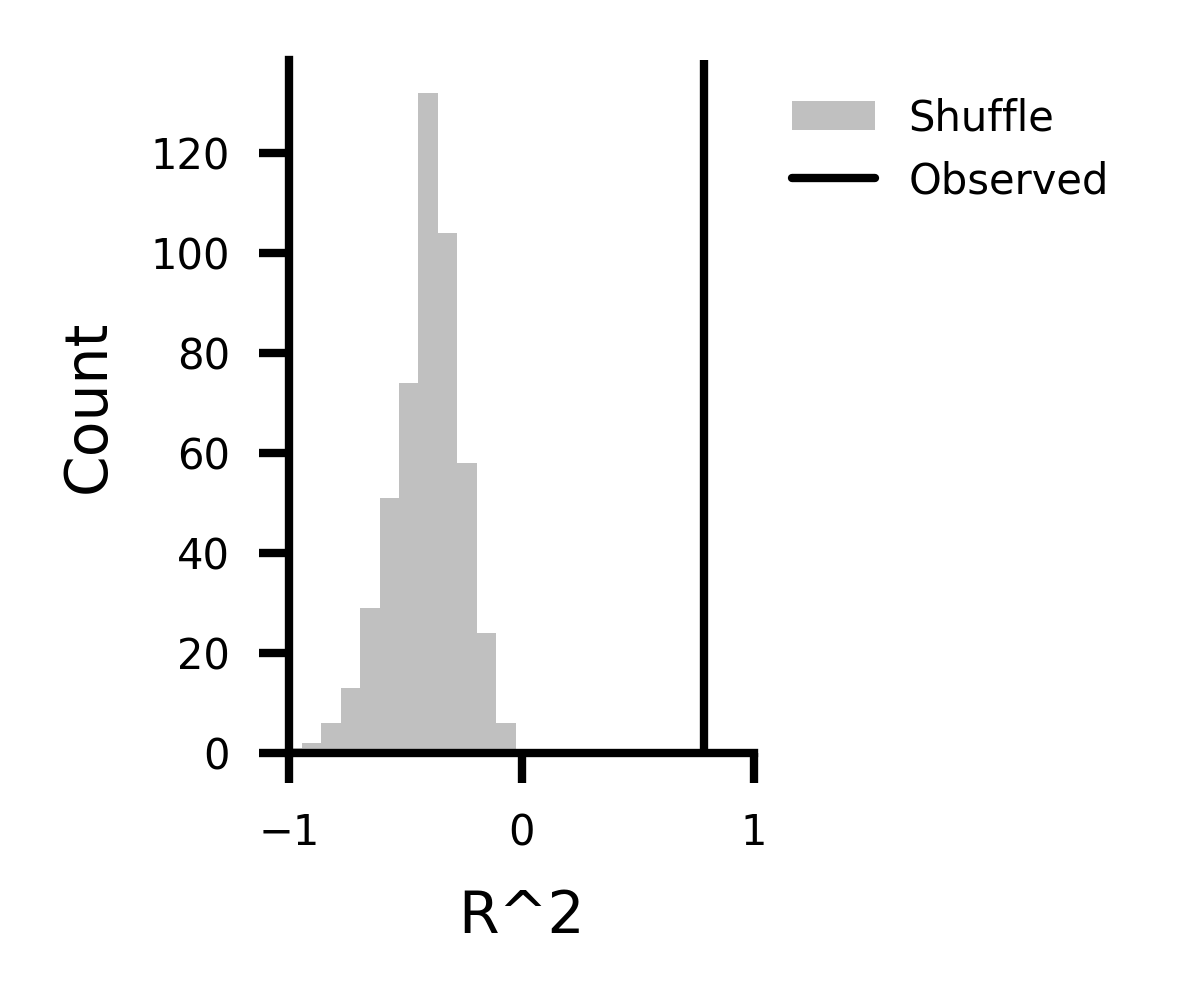

In [72]:
fig = figure(1, 1.5)
ax = sns.histplot(shuff_scores, color='silver', element='step', fill=True, lw=0, label='Shuffle', bins=12, alpha=1)
ax.axvline(score, color='k', label='Observed')
ax.set(xlabel='R^2', xlim=(-1, 1))
plt.legend(frameon=False, bbox_to_anchor=(1, 1), loc='upper left')
sns.despine()
saver(fig, 'syllable-usage-age-shuffle-ontogeny-males');

## TM vs age regression + scatter

In [79]:
pipeline = make_pipeline(
    PLSRegression(n_components=4),
)

y = np.log(tm_mtx.index.get_level_values(0))
preds = cross_val_predict(pipeline, (tm_mtx + 1e-6), y, groups=y.copy(), cv=LeaveOneGroupOut()).squeeze()
score = r2_score(y, preds)
score

0.7488094996502369

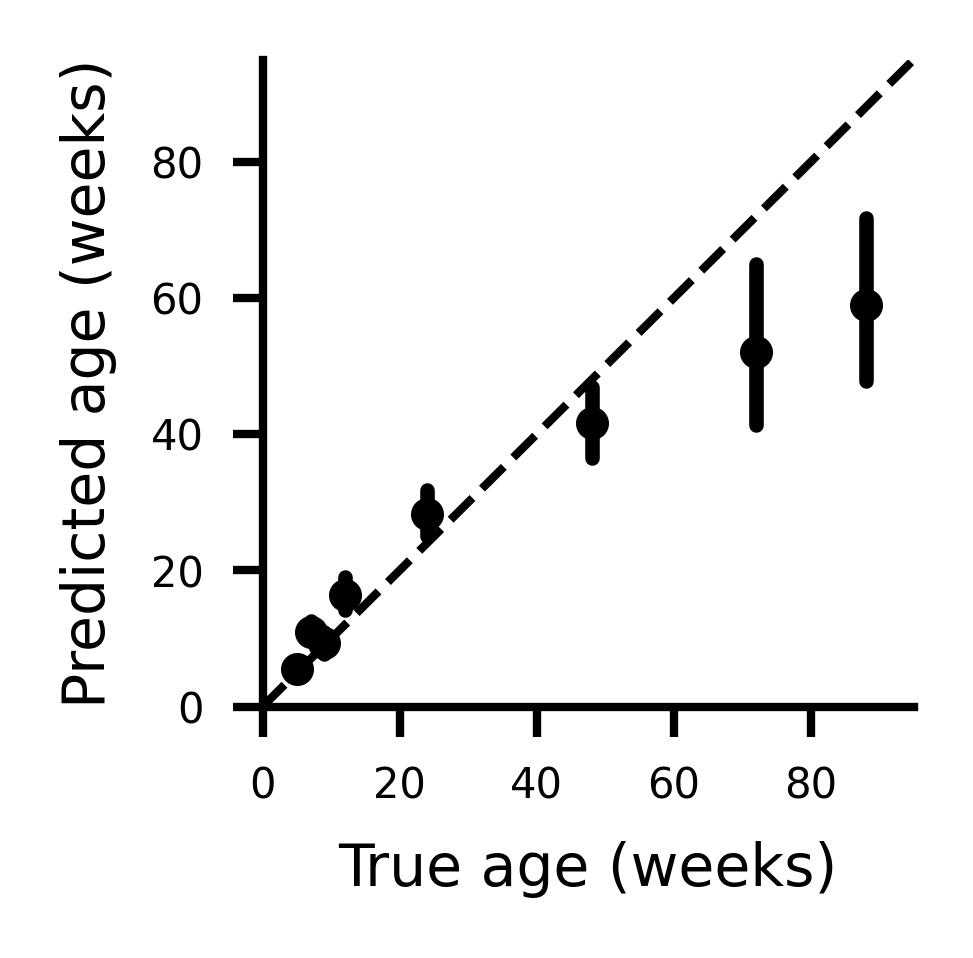

In [75]:
fig = figure(1.4, 1.4)
ax = sns.regplot(y=np.exp(preds), x=np.exp(y), x_bins=9, fit_reg=False, color='k', scatter_kws=dict(s=10))
ax.plot([0, 95], [0, 95], color='k', ls='--', zorder=-5)
ax.set(xlabel='True age (weeks)', ylabel='Predicted age (weeks)', xlim=(0, 95), ylim=(0, 95))
sns.despine()
saver(fig, 'tms-vs-age-regression-ontogeny-males');

In [80]:
n_shuffs = 500
np.random.seed(0)
y = np.log(tm_mtx.index.get_level_values(0)).to_numpy()
lbls = pd.Series(LabelEncoder().fit_transform(y))

shuff_scores = []
for i in tqdm(range(n_shuffs)):
    np.random.shuffle(y)
    preds = cross_val_predict(pipeline, (tm_mtx + 1e-6), y, groups=lbls, cv=LeaveOneGroupOut()).squeeze()
    shuff_scores.append(r2_score(y, preds))

  0%|          | 0/500 [00:00<?, ?it/s]

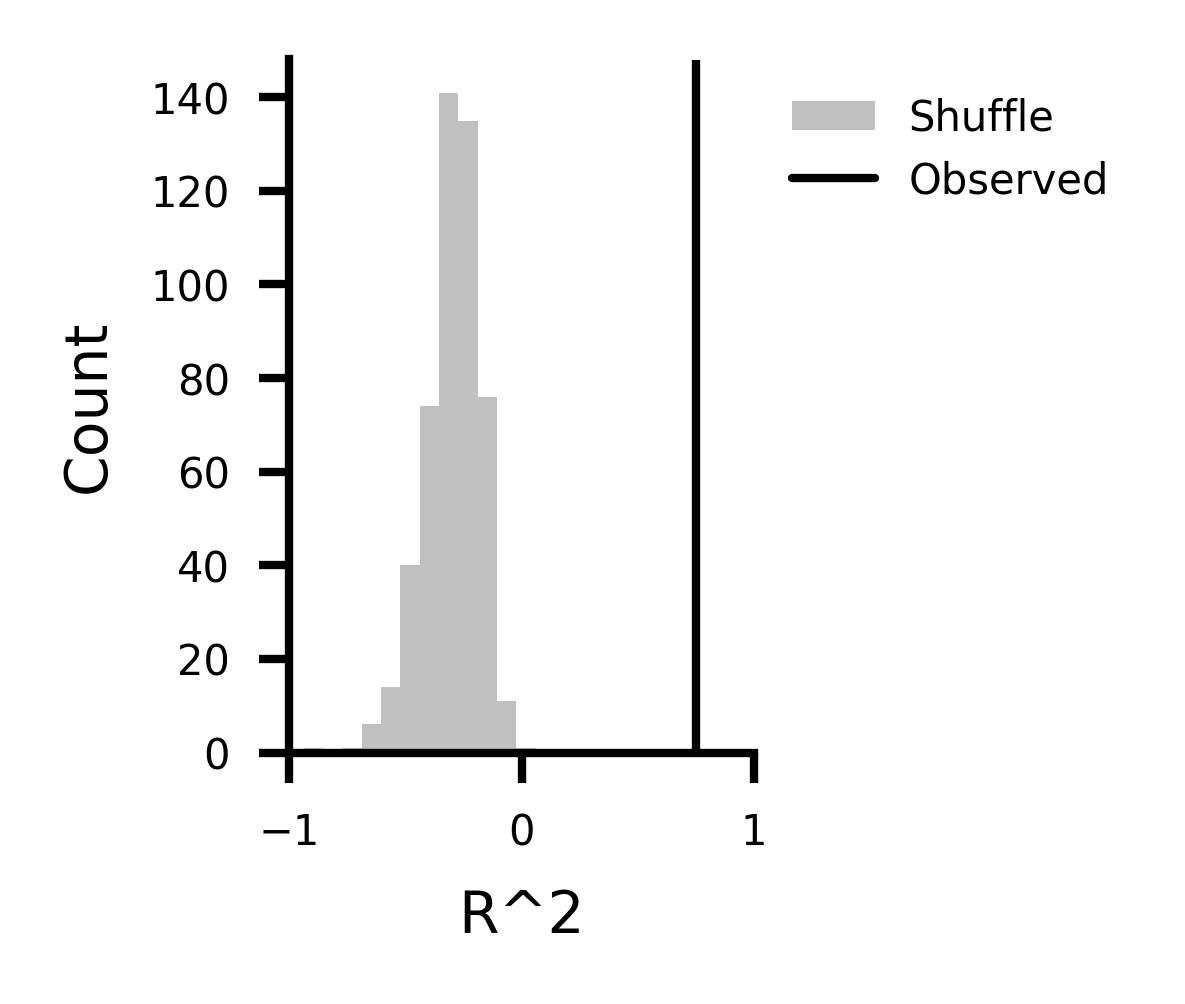

In [81]:
fig = figure(1, 1.5)
ax = sns.histplot(shuff_scores, color='silver', element='step', fill=True, lw=0, label='Shuffle', bins=12, alpha=1)
ax.axvline(score, color='k', label='Observed')
ax.set(xlabel='R^2', xlim=(-1, 1))
plt.legend(frameon=False, bbox_to_anchor=(1, 1), loc='upper left')
sns.despine()
saver(fig, 'tms-vs-age-shuffle-ontogeny-males');

# Females

## Grab regressors from male data

In [36]:
from aging.behavior.syllables import compute_onsets

In [42]:
df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_03/ontogeny_males_syllable_df.parquet"
)
df, usage_map = relabel_by_usage(df)
df["age"] = df["age"].map(age_map)

usage_df = (
    df.query("onsets")
    .groupby(["age", "subject_name", "uuid"])["relabeled_syllables"]
    .value_counts(normalize=True)
)
usage_df.name = "usage"
usage_df = usage_df.reset_index()

usage_mtx = usage_df.pivot_table(
    values="usage", columns="relabeled_syllables", index=["age", "uuid"]
).fillna(0)

In [43]:
male_cols = usage_mtx.columns

In [44]:
pipeline = make_pipeline(
    PLSRegression(n_components=5),
)

y = np.log(usage_mtx.index.get_level_values(0))
out = cross_validate(
    pipeline,
    np.log(usage_mtx + 1e-6),
    y,
    groups=y.copy(),
    cv=LeaveOneGroupOut(),
    return_estimator=True,
)

In [45]:
estimators = out['estimator']

In [46]:
df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_03/ontogeny_females_syllable_df.parquet"
)
df["onsets"] = compute_onsets(df)
df["relabeled_syllables"] = df["syllables"].map(usage_map)
df["age"] = df["age"].map(age_map)

usage_df = (
    df.query("onsets")
    .groupby(["age", "subject_name", "uuid"])["relabeled_syllables"]
    .value_counts(normalize=True)
)
usage_df.name = "usage"
usage_df = usage_df.reset_index()

usage_mtx = usage_df.pivot_table(
    values="usage", columns="relabeled_syllables", index=["age", "uuid"]
).fillna(0)
usage_mtx = usage_mtx.reindex(columns=male_cols, fill_value=0)

In [47]:
usage_mtx

relabeled_syllables                              0         1         2   \
age  uuid                                                                 
3.0  0ae190ba-8ef1-42bb-8528-95c7a8b48388  0.019048  0.018730  0.005714   
     0c3053a4-4cb1-4a13-916e-15a22757cda9  0.011074  0.024732  0.005537   
     0e9b9e38-9a83-407b-b8bb-d027536fa3a4  0.024025  0.033697  0.009048   
     118c174f-3d43-43ef-9b01-44f3a9922e07  0.009811  0.023396  0.008679   
     1d84b318-5a24-4b98-aa33-248ea422c1cd  0.008709  0.015524  0.004922   
...                                             ...       ...       ...   
72.0 d5af8bd8-bc2a-40b4-af2c-b552e8d53e6d  0.040836  0.043052  0.031972   
     e3b8d6dd-fd55-459c-971d-4d21d3a8d5e7  0.023802  0.041082  0.041409   
     e9a9a06a-7299-4e9b-b450-9dd664a4c294  0.031967  0.050035  0.033704   
     eb032189-9827-422c-a161-36048f8225a1  0.049659  0.051210  0.042210   
     f2038ed5-3562-431c-a769-1f78f39cba98  0.064911  0.041947  0.056338   

relabeled_syllables                              3         4         5   \
age  uuid                                                                 
3.0  0ae190ba-8ef1-42bb-8528-95c7a8b48388  0.034286  0.011429  0.005397   
     0c3053a4-4cb1-4a13-916e-15a22757cda9  0.028055  0.012182  0.007752   
     0e9b9e38-9a83-407b-b8bb-d027536fa3a4  0.042122  0.020281  0.014665   
     118c174f-3d43-43ef-9b01-44f3a9922e07  0.040377  0.007170  0.004528   
     1d84b318-5a24-4b98-aa33-248ea422c1cd  0.032185  0.012495  0.003786   
...                                             ...       ...       ...   
72.0 d5af8bd8-bc2a-40b4-af2c-b552e8d53e6d  0.042102  0.058246  0.046534   
     e3b8d6dd-fd55-459c-971d-4d21d3a8d5e7  0.033583  0.048256  0.028366   
     e9a9a06a-7299-4e9b-b450-9dd664a4c294  0.033009  0.051772  0.022238   
     eb032189-9827-422c-a161-36048f8225a1  0.040037  0.038796  0.028554   
     f2038ed5-3562-431c-a769-1f78f39cba98  0.046846  0.045928  0.048683   

relabeled_syllables                              6         7         8   \
age  uuid                                                                 
3.0  0ae190ba-8ef1-42bb-8528-95c7a8b48388  0.008889  0.047619  0.017460   
     0c3053a4-4cb1-4a13-916e-15a22757cda9  0.021410  0.063123  0.021041   
     0e9b9e38-9a83-407b-b8bb-d027536fa3a4  0.023713  0.064899  0.027145   
     118c174f-3d43-43ef-9b01-44f3a9922e07  0.015094  0.063019  0.015094   
     1d84b318-5a24-4b98-aa33-248ea422c1cd  0.015903  0.061340  0.010602   
...                                             ...       ...       ...   
72.0 d5af8bd8-bc2a-40b4-af2c-b552e8d53e6d  0.040519  0.018360  0.038936   
     e3b8d6dd-fd55-459c-971d-4d21d3a8d5e7  0.031627  0.032605  0.029671   
     e9a9a06a-7299-4e9b-b450-9dd664a4c294  0.038568  0.023280  0.023975   
     eb032189-9827-422c-a161-36048f8225a1  0.049038  0.017070  0.051210   
     f2038ed5-3562-431c-a769-1f78f39cba98  0.055113  0.017453  0.040110   

relabeled_syllables                              9   ...        53        54  \
age  uuid                                            ...                       
3.0  0ae190ba-8ef1-42bb-8528-95c7a8b48388  0.049206  ...  0.008889  0.013651   
     0c3053a4-4cb1-4a13-916e-15a22757cda9  0.060539  ...  0.013289  0.005537   
     0e9b9e38-9a83-407b-b8bb-d027536fa3a4  0.038066  ...  0.007800  0.007176   
     118c174f-3d43-43ef-9b01-44f3a9922e07  0.043774  ...  0.016604  0.012075   
     1d84b318-5a24-4b98-aa33-248ea422c1cd  0.040136  ...  0.010223  0.019690   
...                                             ...  ...       ...       ...   
72.0 d5af8bd8-bc2a-40b4-af2c-b552e8d53e6d  0.014245  ...  0.000950  0.000950   
     e3b8d6dd-fd55-459c-971d-4d21d3a8d5e7  0.024454  ...  0.000000  0.000326   
     e9a9a06a-7299-4e9b-b450-9dd664a4c294  0.024322  ...  0.000695  0.002085   
     eb032189-9827-422c-a161-36048f8225a1  0.014277  ...  0.005276  0.001241   
     f2038ed5-3562-431c-a769-1f78f39cba98  0.018677  ...  0.004593  0.002756   

relabeled_syllables            

In [48]:
predictions = [e.predict(np.log(usage_mtx + 1e-6)).squeeze() for e in estimators]

In [49]:
avg_predictions = np.mean(predictions, axis=0)

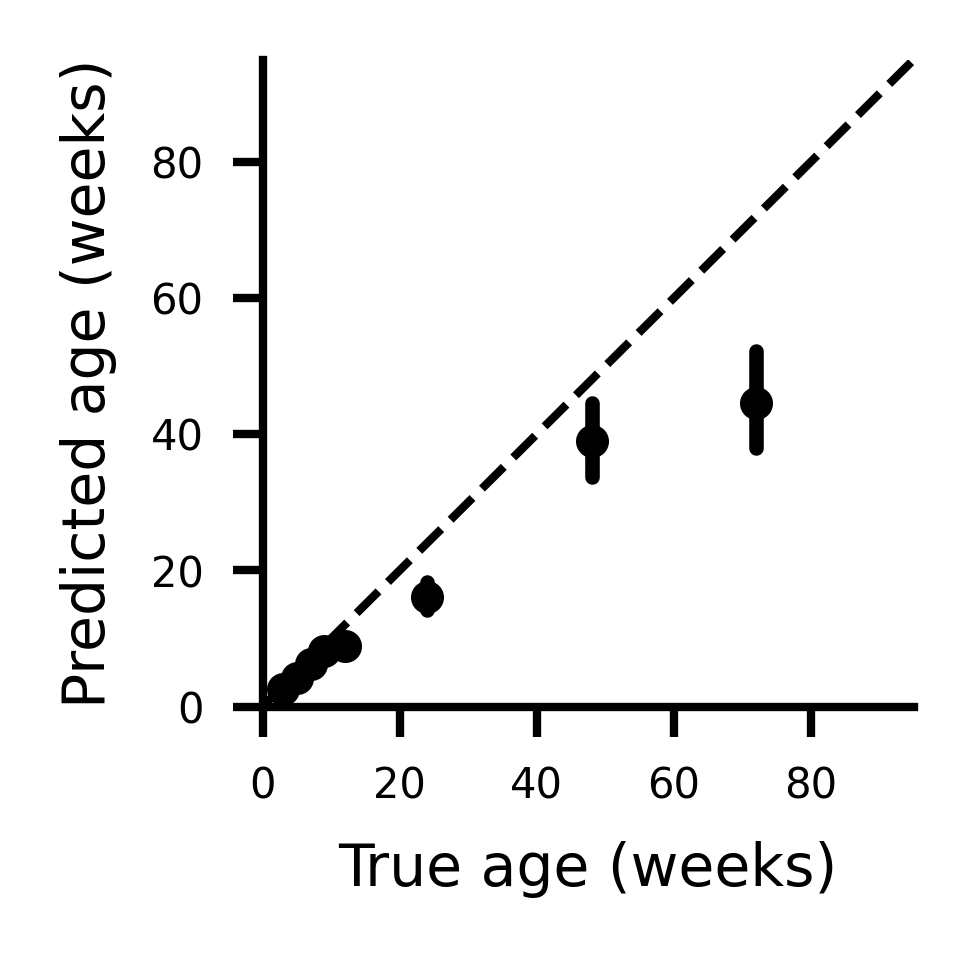

In [50]:
fig = figure(1.4, 1.4)
ages = usage_mtx.index.get_level_values(0)
ax = sns.regplot(
    y=np.exp(avg_predictions),
    x=ages,
    x_bins=len(np.unique(ages)),
    fit_reg=False,
    color="k",
    scatter_kws=dict(s=10),
)
ax.plot([0, 95], [0, 95], color="k", ls="--", zorder=-5)
ax.set(
    xlabel="True age (weeks)",
    ylabel="Predicted age (weeks)",
    xlim=(0, 95),
    ylim=(0, 95),
)
sns.despine()
saver(fig, "syllable-usage-age-regression-ontogeny-females-projected-on-males");

In [51]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_03/ontogeny_females_syllable_df.parquet')
df['onsets'] = compute_onsets(df)
df['relabeled_syllables'] = df['syllables'].map(usage_map)
df['age'] = df['age'].map(age_map)

usage_df = df.query('onsets').groupby(['age', 'subject_name', 'uuid'])['relabeled_syllables'].value_counts(normalize=True)
usage_df.name = 'usage'
usage_df = usage_df.reset_index()

usage_mtx = usage_df.pivot_table(values='usage', columns='relabeled_syllables', index=['age', 'uuid']).fillna(0)
usage_mtx = usage_mtx.reindex(columns=male_cols, fill_value=0)

In [52]:
pipeline = make_pipeline(
    PLSRegression(n_components=5),
)

y = np.log(usage_mtx.index.get_level_values(0))
out = cross_validate(
    pipeline,
    np.log(usage_mtx + 1e-6),
    y,
    groups=y.copy(),
    cv=LeaveOneGroupOut(),
    return_estimator=True,
)

In [53]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_03/ontogeny_males_syllable_df.parquet')
df['onsets'] = compute_onsets(df)
df['relabeled_syllables'] = df['syllables'].map(usage_map)
df['age'] = df['age'].map(age_map)

usage_df = df.query('onsets').groupby(['age', 'subject_name', 'uuid'])['relabeled_syllables'].value_counts(normalize=True)
usage_df.name = 'usage'
usage_df = usage_df.reset_index()

usage_mtx = usage_df.pivot_table(values='usage', columns='relabeled_syllables', index=['age', 'uuid']).fillna(0)
usage_mtx = usage_mtx.reindex(columns=male_cols, fill_value=0)

In [54]:
predictions = [e.predict(np.log(usage_mtx + 1e-6)).squeeze() for e in estimators]
avg_predictions = np.mean(predictions, axis=0)

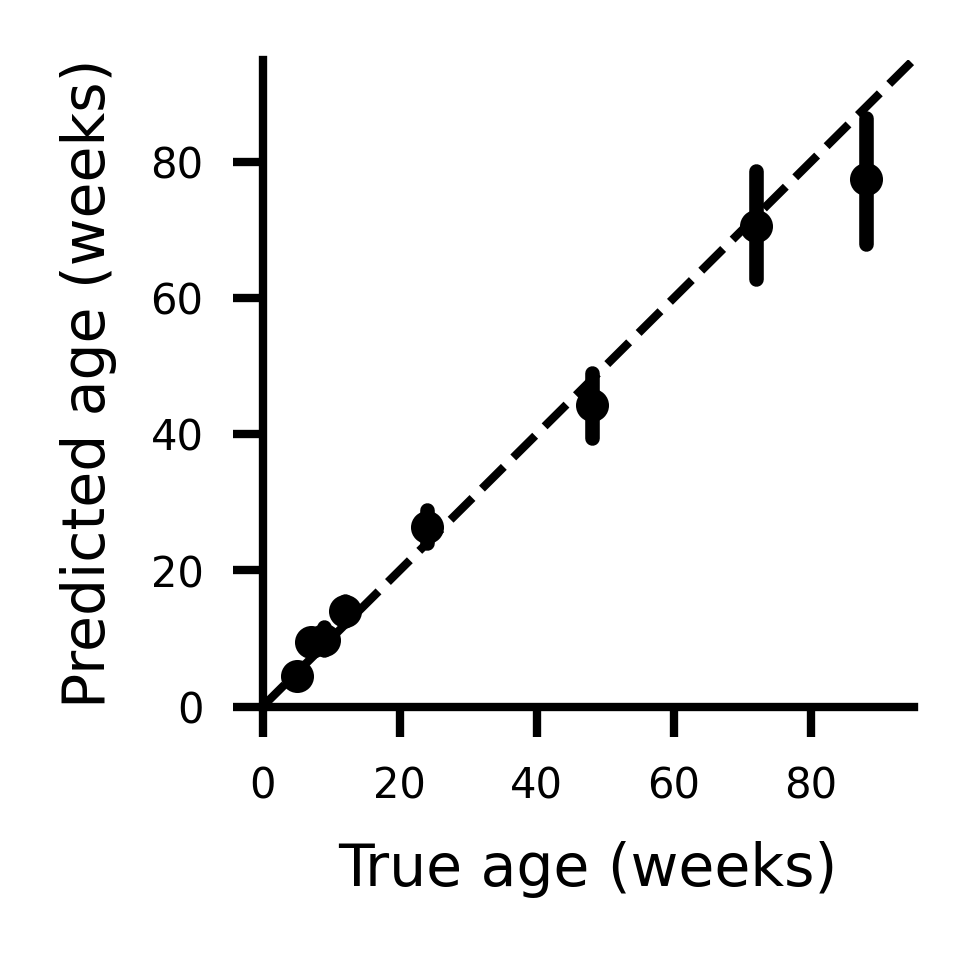

In [55]:
fig = figure(1.4, 1.4)
ages = usage_mtx.index.get_level_values(0)
ax = sns.regplot(
    y=np.exp(avg_predictions),
    x=ages,
    x_bins=len(np.unique(ages)),
    fit_reg=False,
    color="k",
    scatter_kws=dict(s=10),
)
ax.plot([0, 95], [0, 95], color="k", ls="--", zorder=-5)
ax.set(
    xlabel="True age (weeks)",
    ylabel="Predicted age (weeks)",
    xlim=(0, 95),
    ylim=(0, 95),
)
sns.despine()
saver(fig, "syllable-usage-age-regression-ontogeny-males-projected-on-females");

## Random forest regressor

In [100]:
param_grid = dict(randomforestregressor__n_estimators=range(50, 151, 50))
grid = ParameterGrid(param_grid)

pipeline = make_pipeline(
    RandomForestRegressor(),
)

y = (usage_mtx.index.get_level_values(0))
lbls = LabelEncoder().fit_transform(y)

output = []
folds = StratifiedKFold(n_splits=6)

for param in tqdm(grid):
    mdl = pipeline.set_params(**param)
    preds = np.zeros_like(y)
    for train, test in folds.split(usage_mtx, lbls):
        pipeline = pipeline.fit(np.log(usage_mtx.iloc[train] + 1e-6), y[train])
        preds[test] = pipeline.predict(np.log(usage_mtx.iloc[test] + 1e-6)).squeeze()
    output.append(dict(params=param, score=r2_score(y, preds)))

out = pd.DataFrame(output)
out = out.sort_values(by="score", ascending=False)
out.head()

  0%|          | 0/3 [00:00<?, ?it/s]

,params,score
1,{'randomforestregressor__n_estimators': 100},0.790193
2,{'randomforestregressor__n_estimators': 150},0.788969
0,{'randomforestregressor__n_estimators': 50},0.779686


In [101]:
pipeline = pipeline.set_params(**out.iloc[0]['params'])
y = (usage_mtx.index.get_level_values(0))
lbls = LabelEncoder().fit_transform(y)

preds = np.zeros_like(y)
folds = StratifiedKFold(n_splits=6)
for train, test in folds.split(usage_mtx, lbls):
    pipeline = pipeline.fit(np.log(usage_mtx.iloc[train] + 1e-6), y[train])
    preds[test] = pipeline.predict(np.log(usage_mtx.iloc[test] + 1e-6)).squeeze()
plt_out['rf'] = (y, preds)
print(r2_score(y, preds))

0.7810066094196303


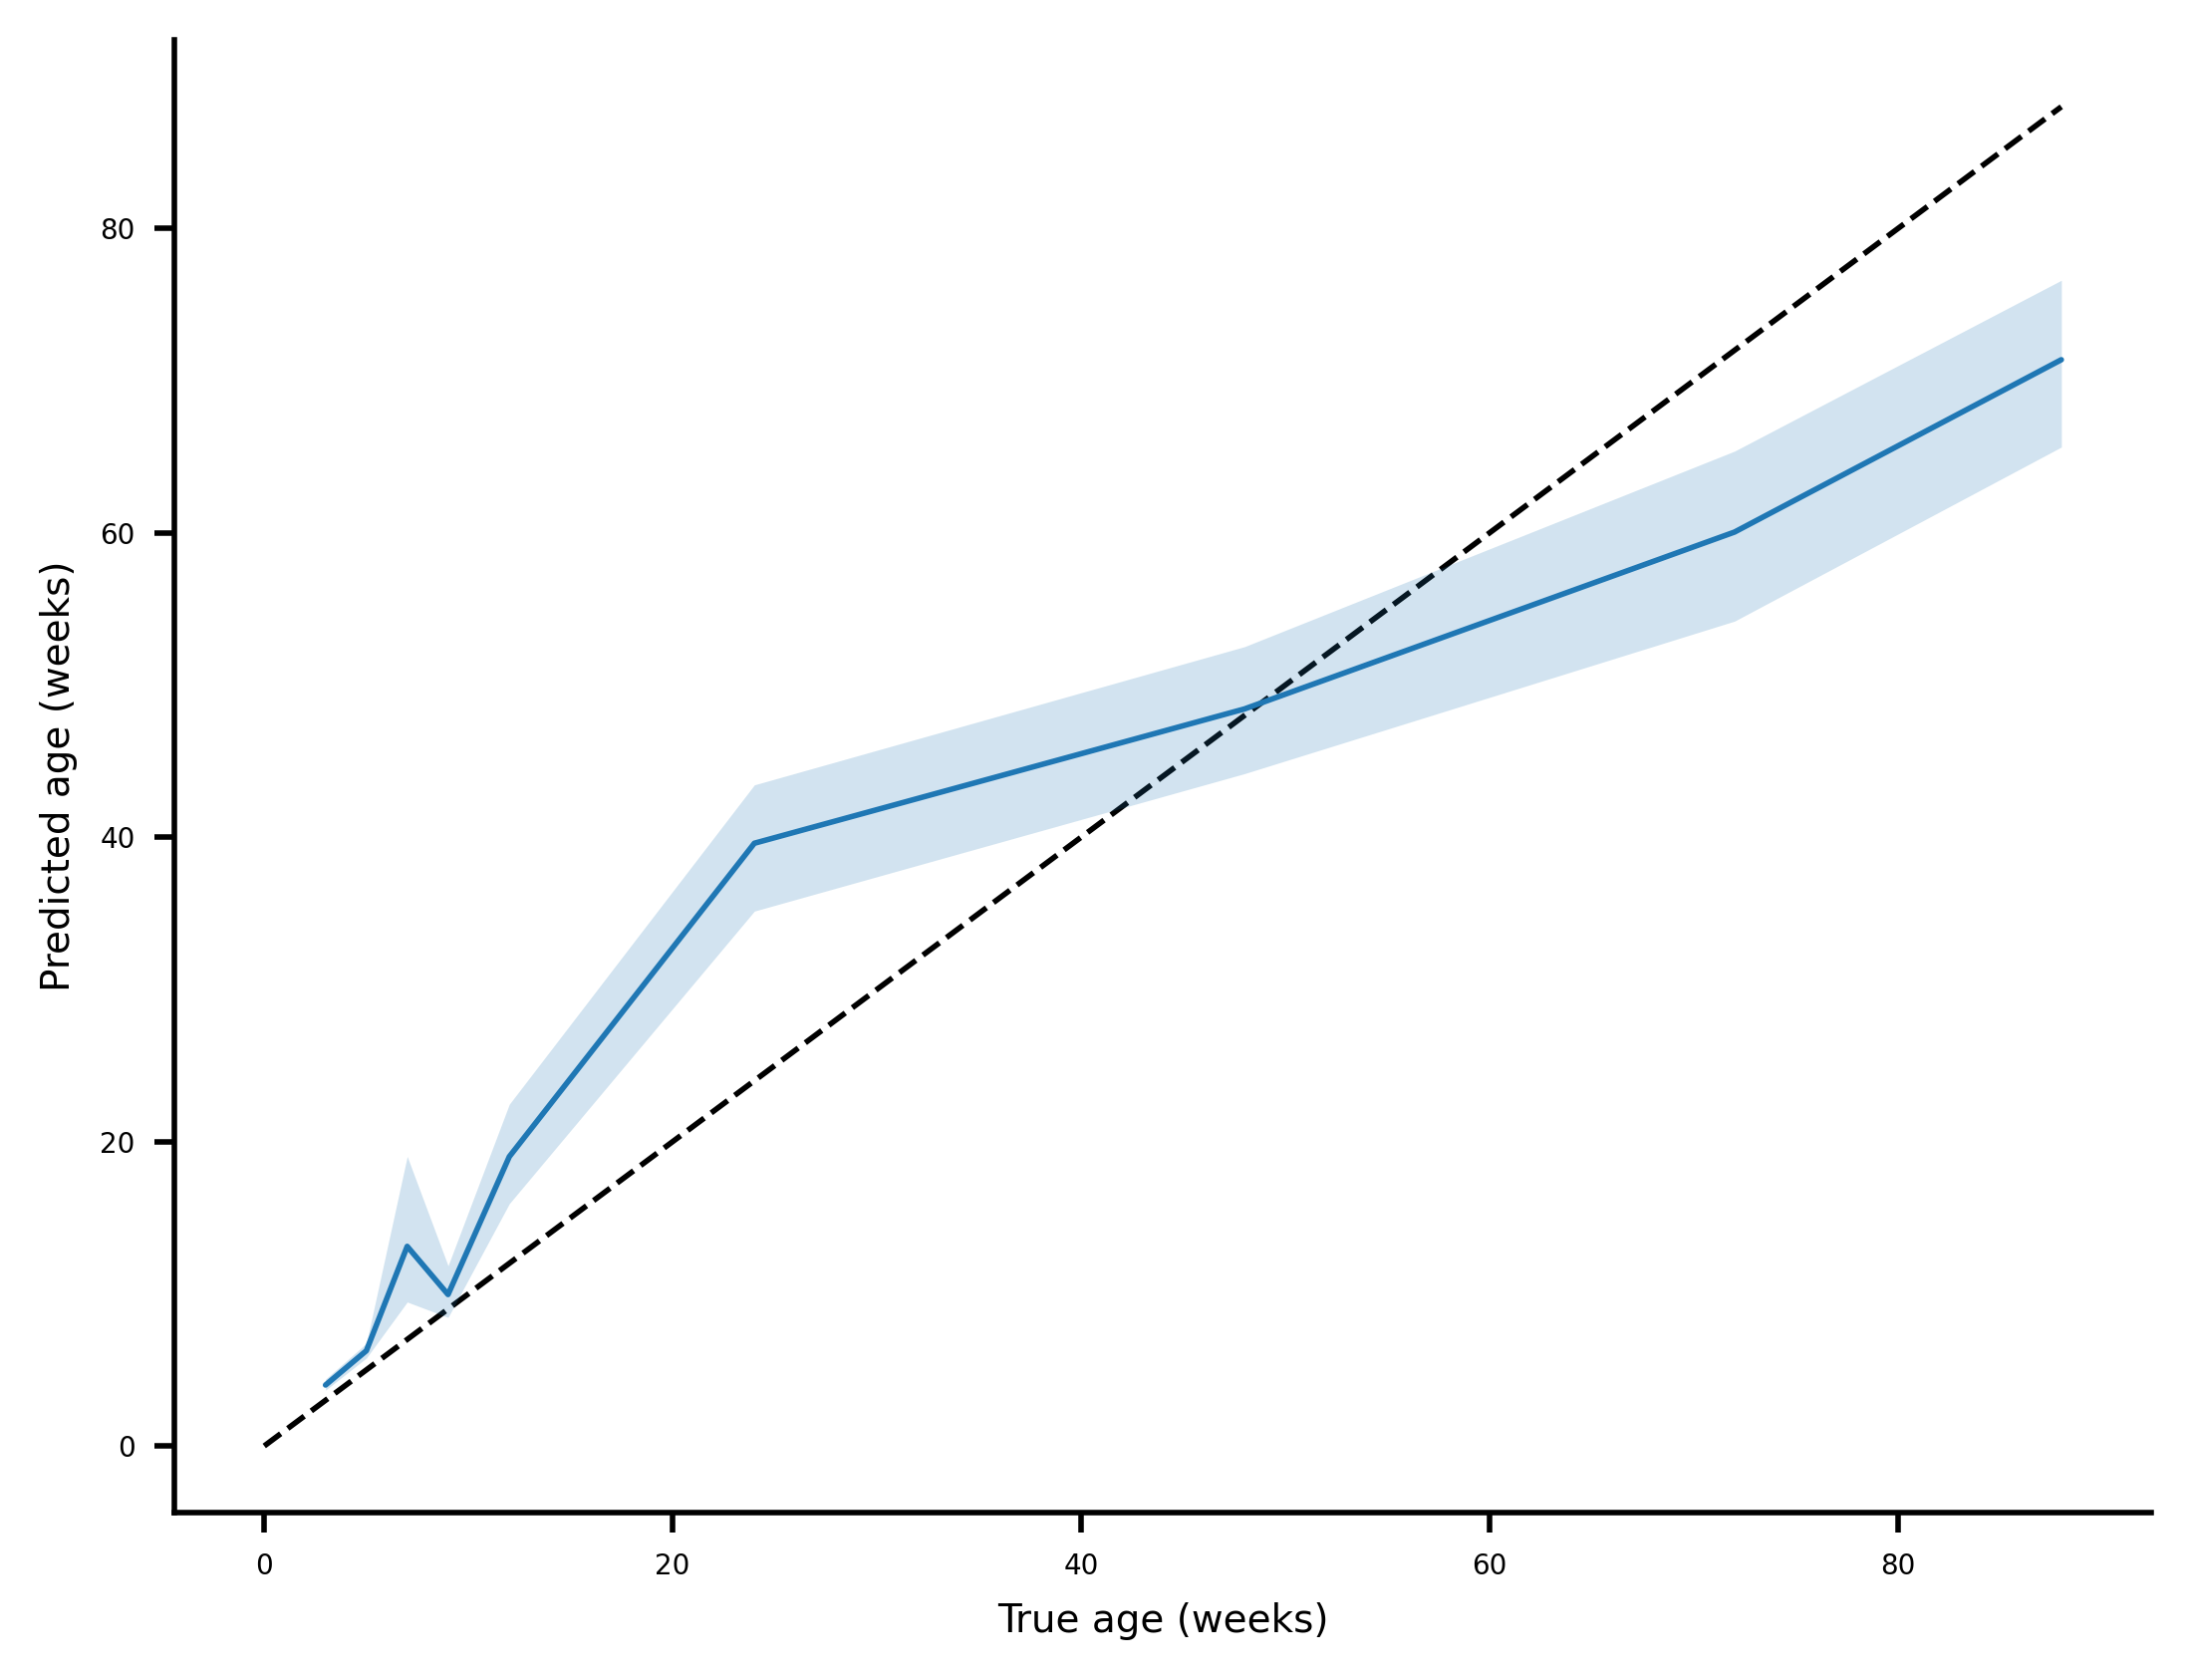

In [102]:
ax = sns.lineplot(y=(preds), x=(y), err_kws=dict(lw=0), zorder=5)
ax.plot([0, 88], [0, 88], color='k', ls='--', zorder=-5)
ax.set(xlabel='True age (weeks)', ylabel='Predicted age (weeks)')
sns.despine()

In [86]:
for k, v in plt_out.items():
    print(k, r2_score(*v))

pls 0.7911213957572996
rf 0.7936524017939685


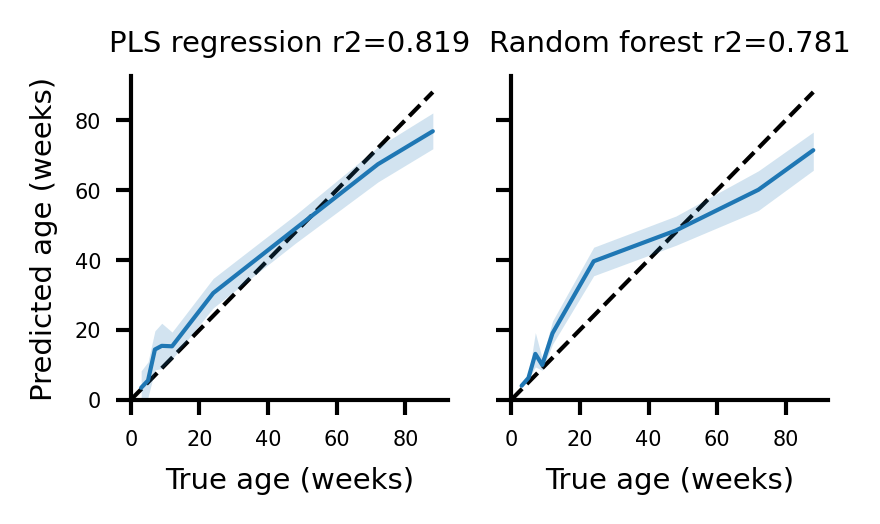

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(3, 1.4), dpi=150, sharex=True, sharey=True)
sns.lineplot(
    x=plt_out["pls"][0], y=plt_out["pls"][1], ax=ax[0], err_kws=dict(lw=0), zorder=1
)
sns.lineplot(
    x=plt_out["rf"][0], y=plt_out["rf"][1], ax=ax[1], err_kws=dict(lw=0), zorder=1
)
title_map = dict(pls="PLS regression", rf="Random forest")
for a, (k, v) in zip(ax.flat, plt_out.items()):
    r2 = r2_score(*v)
    a.plot([0, 88], [0, 88], color="k", ls="--", zorder=-5)
    a.set(
        xlabel="True age (weeks)",
        ylabel="Predicted age (weeks)",
        xlim=(0, None),
        ylim=(0, None),
        title=f"{title_map[k]} r2={r2:0.3f}",
    )
sns.despine()